## Исследование интернет-магазина компьютерных игр

**Задача:** Выявить определяющие финансовый успех игр закономерности

Предоставлены [данные](https://code.s3.yandex.net/datasets/games.csv) о продажах игр по всему миру из открытых источников.

Данные включают в себя следующие фичи:
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

**План работ:**

1. Предобработка данных. Анализ пропущенныз значений, их возможное заполнение, редактирование форматов данных.
2. Создание новых параметров из старых значений.
3. Исследовательский анализ данных.
4. Создание портретов пользователей по регионам.
5. Формулирование и проверка гипотез о равенстве пользовательских рейтингов для платформ и разности рейтингов игр в жанрах *спорт* и *экшн*
6. Вывод

## Обзор данных

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats as st
from pymystem3 import Mystem
from pymorphy2 import MorphAnalyzer
import re

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

In [3]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
data.shape

(16715, 11)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Year_of_Release стоит перевести в формат даты. User_Score будет приведен в float формат.

Посмотрим на количество явных дубликатов и распределения признаков

In [6]:
data.duplicated().sum()

0

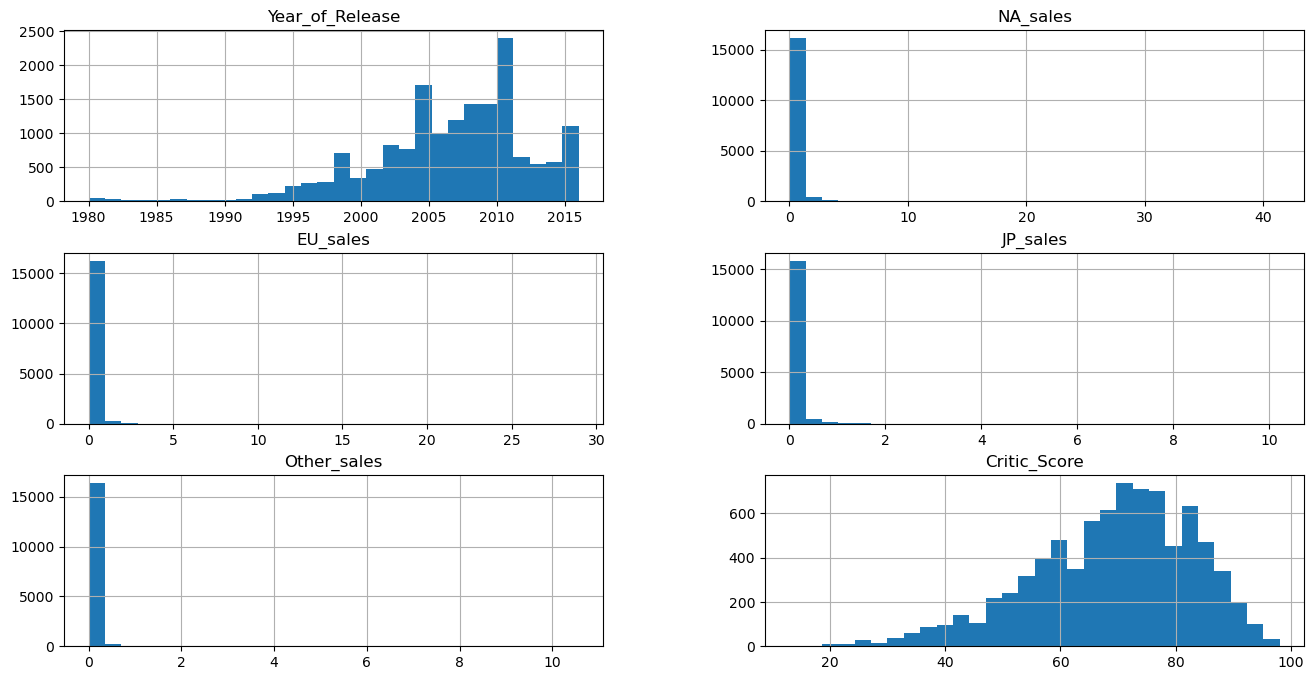

In [7]:
data.hist(figsize=(16,8), bins=30);

На гистограммах продаж наблюдаются редкие, сильно выбивающиеся значения, которые предстоит убрать. 

На гистограмме года релиза наблюдаются анамальные значения с 1980 по 1990~ и 4 ярких пика, со значениями в 2 раза больше чем за предшествующие года.

В то же время, на гистограмме оценок критиков наблюдаются 2 яркие просадки оценок.

Посмотрим на отсутствующие значения признаков.

In [8]:
pd.DataFrame(data.isna().mean() * 100).style.format('{0:.2f}')

,0
Name,0.01
Platform,0.00
Year_of_Release,1.61
Genre,0.01
NA_sales,0.00
EU_sales,0.00
JP_sales,0.00
Other_sales,0.00
Critic_Score,51.32
User_Score,40.09


Самые значимая доля пропущенных значений находится в колонках оценок критиков (51%) и пользователей (40%), а так же в возрастном рейтинге (40.5%).

В колонке Год релиза наблюдаются 1.6% пропусков, что не кретично.

В колонках названия и жанра по 0.01%, чем можно пренебречь и удалить эти данные.

## Предобработка данных

Приведем названия столбцок в к нижнему регистру.

In [9]:
data.columns = ['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales', 
                'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating']

### Столбец name

In [10]:
data[data.name.isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


2 значения в колонке Name неопределены, их количество незначительно и их можно удалить.

In [11]:
data = data[~data.name.isna()]

Просмотрим уникальные значения в колонке

In [12]:
data.name.unique().tolist()

['Wii Sports',
 'Super Mario Bros.',
 'Mario Kart Wii',
 'Wii Sports Resort',
 'Pokemon Red/Pokemon Blue',
 'Tetris',
 'New Super Mario Bros.',
 'Wii Play',
 'New Super Mario Bros. Wii',
 'Duck Hunt',
 'Nintendogs',
 'Mario Kart DS',
 'Pokemon Gold/Pokemon Silver',
 'Wii Fit',
 'Kinect Adventures!',
 'Wii Fit Plus',
 'Grand Theft Auto V',
 'Grand Theft Auto: San Andreas',
 'Super Mario World',
 'Brain Age: Train Your Brain in Minutes a Day',
 'Pokemon Diamond/Pokemon Pearl',
 'Super Mario Land',
 'Super Mario Bros. 3',
 'Grand Theft Auto: Vice City',
 'Pokemon Ruby/Pokemon Sapphire',
 'Brain Age 2: More Training in Minutes a Day',
 'Pokemon Black/Pokemon White',
 'Gran Turismo 3: A-Spec',
 'Call of Duty: Modern Warfare 3',
 'Pokémon Yellow: Special Pikachu Edition',
 'Call of Duty: Black Ops 3',
 'Call of Duty: Black Ops',
 'Pokemon X/Pokemon Y',
 'Call of Duty: Black Ops II',
 'Call of Duty: Modern Warfare 2',
 'Grand Theft Auto III',
 'Super Smash Bros. Brawl',
 'Mario Kart 7',
 'Ani

In [13]:
data.shape[0]

16713

In [14]:
data.name.nunique() # Всего  уникалных имён

11559

In [15]:
data[data.name == 'New Super Mario Bros. Wii']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.7,2.24,87.0,8.4,E


Всего в наших данных 16715 значений, из них 11559 уникальных названий.

In [16]:
data.groupby('name').count()['platform'].sort_values(ascending=False).head(10)

name
Need for Speed: Most Wanted    12
LEGO Marvel Super Heroes        9
Ratatouille                     9
Madden NFL 07                   9
FIFA 14                         9
LEGO Jurassic World             8
Madden NFL 08                   8
Monopoly                        8
FIFA 15                         8
LEGO The Hobbit                 8
Name: platform, dtype: int64

In [17]:
data[data.name == 'Need for Speed: Most Wanted']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
253,Need for Speed: Most Wanted,PS2,2005.0,Racing,2.03,1.79,0.08,0.47,82.0,9.1,T
523,Need for Speed: Most Wanted,PS3,2012.0,Racing,0.71,1.46,0.06,0.58,NaN,NaN,NaN
1190,Need for Speed: Most Wanted,X360,2012.0,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
1591,Need for Speed: Most Wanted,X360,2005.0,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T
1998,Need for Speed: Most Wanted,XB,2005.0,Racing,0.53,0.46,0.00,0.05,83.0,8.8,T
2048,Need for Speed: Most Wanted,PSV,2012.0,Racing,0.33,0.45,0.01,0.22,NaN,NaN,NaN
3581,Need for Speed: Most Wanted,GC,2005.0,Racing,0.43,0.11,0.00,0.02,80.0,9.1,T
5972,Need for Speed: Most Wanted,PC,2005.0,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T
6273,Need for Speed: Most Wanted,WiiU,2013.0,Racing,0.13,0.12,0.00,0.02,NaN,NaN,NaN
6410,Need for Speed: Most Wanted,DS,2005.0,Racing,0.24,0.01,0.00,0.02,45.0,6.1,E


Многие названиия повторяются несколько раз, это связанно с релизами на различных платфорамах и в разных годах. После лемматизации и обработки столбцов платформ, года выпуска, жанра и рейтинга стоит провести проверку дубликатов по ним.

Создадим функцию, которая расскладывает строку на леммы и складывает все обратно в строку.

In [18]:
morph = MorphAnalyzer()

def lemmatize_text(text):
    words = text.split() # Разделяем текст на слова
    lst = []
    for word in words:
        if not re.match(r'\W', word): # с помощью импортируемой библиотеки re фильтруем элементы в списке
            lst.append(word.lower())
    res = []

    for word in lst:
        p = morph.parse(word)[0] # Получаем лемму в нинем регистре
        res.append(p.normal_form)
    return ' '.join(res) # Соединяем слова обратно в текст

In [19]:
data['name'] = data['name'].apply(lemmatize_text)

In [20]:
data.name

0                           wii sports
1                    super mario bros.
2                       mario kart wii
3                    wii sports resort
4             pokemon red/pokemon blue
                     ...              
16710    samurai warriors: sanada maru
16711                 lma manager 2007
16712          haitaka no psychedelica
16713                   spirits spells
16714              winning post 8 2016
Name: name, Length: 16713, dtype: object

In [21]:
data.name.nunique()

11472

Удалось убрать 87 повторяющихся названия.

### Столбец platform

In [22]:
data.platform.unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [23]:
data.platform.nunique()

31

In [24]:
data.platform.value_counts()

PS2     2161
DS      2151
PS3     1331
Wii     1320
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
GC       556
3DS      520
PSV      430
PS4      392
N64      319
XOne     247
SNES     239
SAT      173
WiiU     147
2600     133
NES       98
GB        98
DC        52
GEN       27
NG        12
SCD        6
WS         6
3DO        3
TG16       2
GG         1
PCFX       1
Name: platform, dtype: int64

Стоит убрать последние 8 платформ из наших данных, т.к. их значения крайне редки.

In [25]:
data = data[~data.platform.isin(['PCFX', 'GG', 'TG16', '3DO', 'SCD', 'WS', 'NG', 'GEN'])]

### Столбец year_of_release

In [26]:
data.shape[0]

16655

In [27]:
data[data.year_of_release.isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,madden nfl 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,fifa soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,lego batman: the videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe smackdown vs. raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,space invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,pdc world championship darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16405,freaky flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,hakuouki: shinsengumi kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Количество пропущенных значений мало, скорее всего они возникают из-за особенности сайта, на которых брались данные и парсер пропустил значения или же они не были указаны вовсе.

In [28]:
data[data.name == 'madden nfl 2004']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,madden nfl 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
1881,madden nfl 2004,XB,2003.0,Sports,1.02,0.02,0.00,0.05,92.0,8.3,E
3889,madden nfl 2004,GC,2003.0,Sports,0.40,0.10,0.00,0.01,94.0,7.7,E
5708,madden nfl 2004,GBA,2003.0,Sports,0.22,0.08,0.00,0.01,70.0,6.6,E


Во многих случаях, строки с пропущенными годами выпуска имеют дату на других платформах. Стоит заполнить пропущенные значения ими.

In [29]:
# Решил построчно изменить данные, т.к. количество итераций мало

for i in data[data.year_of_release.isna()].index:
    try:
        mask = data.loc[i]['name']
        filler = data[data.name == mask].year_of_release.mode()[0]
        data.loc[i, 'year_of_release'] = filler
    except:
        continue

In [30]:
data[data.year_of_release.isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
475,wwe smackdown vs. raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
627,rock band,X360,NaN,Misc,1.93,0.33,0.00,0.21,92.0,8.2,T
657,frogger's adventures: temple of the frog,GBA,NaN,Adventure,2.15,0.18,0.00,0.07,73.0,tbd,E
805,rock band,Wii,NaN,Misc,1.33,0.56,0.00,0.20,80.0,6.3,T
1142,rock band,PS3,NaN,Misc,0.99,0.41,0.00,0.22,92.0,8.4,T
...,...,...,...,...,...,...,...,...,...,...,...
16277,homeworld remastered collection,PC,NaN,Strategy,0.00,0.01,0.00,0.00,86.0,8.2,E10+
16288,shorts,DS,NaN,Platform,0.01,0.00,0.00,0.00,NaN,tbd,E10+
16348,agarest senki: re-appearance,PS3,NaN,Role-Playing,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16458,hakuouki: shinsengumi kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Удалось установить 123 значения.

Остальные 145 значений стоит удалить. Т.к. восстановить пропущенные значения не представляется возможным.

In [31]:
data.dropna(subset=['year_of_release'], inplace=True)

Изучим распределение количества выхода игр по годам.

In [32]:
data.year_of_release.value_counts().to_frame()

,year_of_release
2008.0,1441
2009.0,1430
2010.0,1270
2007.0,1202
2011.0,1153
2006.0,1019
2005.0,948
2002.0,845
2003.0,783
2004.0,764


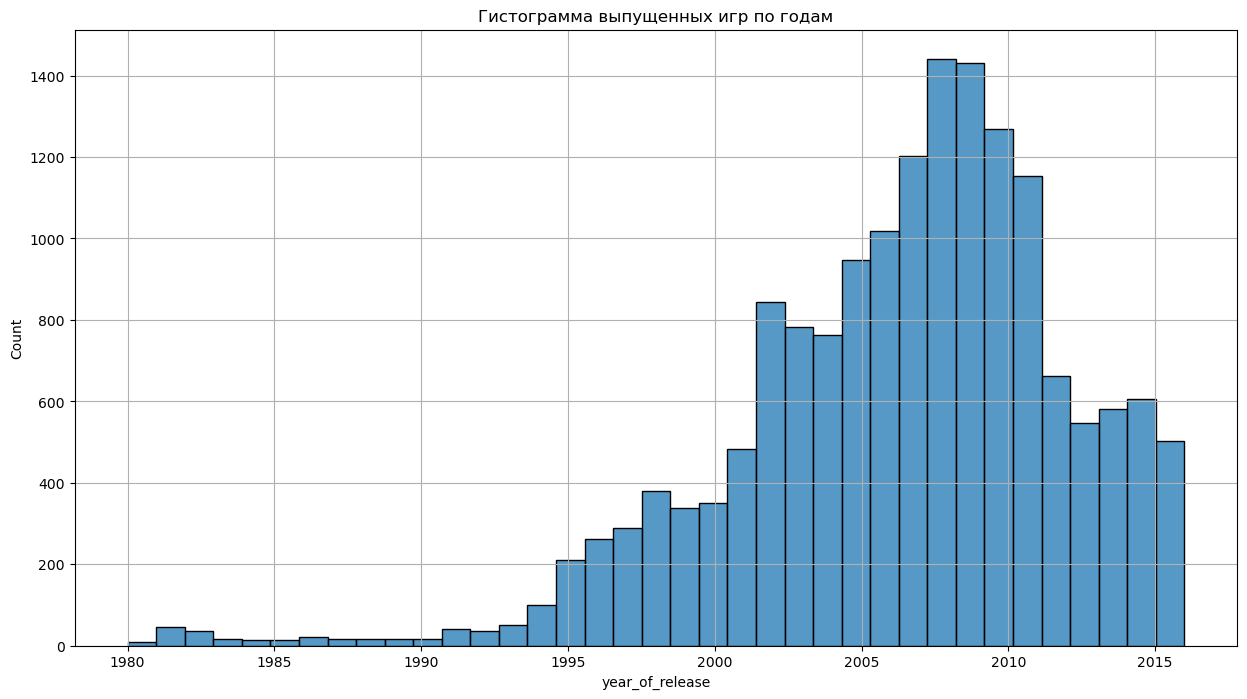

In [33]:
plt.figure(figsize=(15, 8))
sns.histplot(data.year_of_release, bins=data.year_of_release.nunique())
plt.grid(True)
plt.title('Гистограмма выпущенных игр по годам');

Значения до 1994 года довольно редки и они могут исказить наши данные. Их стоит удалить

In [34]:
data = data[~data.year_of_release.between(1980, 1993)]

Удалось восстановить 124 значения года выпуска, и было удалено 491 значения в этом блоке.

Поменяем формат данных.

In [35]:
data['year_of_release'] = pd.to_datetime(data['year_of_release'], format='%Y').dt.year

### Столбец genre

In [36]:
data.genre.isna().sum()

0

In [37]:
data.genre.unique()

array(['Sports', 'Racing', 'Role-Playing', 'Platform', 'Misc',
       'Simulation', 'Action', 'Puzzle', 'Shooter', 'Fighting',
       'Adventure', 'Strategy'], dtype=object)

Посмотрим на распределение игр по жанрам. Создадим колонку и столбчатую диаграмму

In [38]:
data.genre.value_counts().to_frame().reset_index()

,index,genre
0,Action,3261
1,Sports,2284
2,Misc,1718
3,Role-Playing,1446
4,Adventure,1283
5,Shooter,1272
6,Racing,1219
7,Simulation,851
8,Platform,816
9,Fighting,808


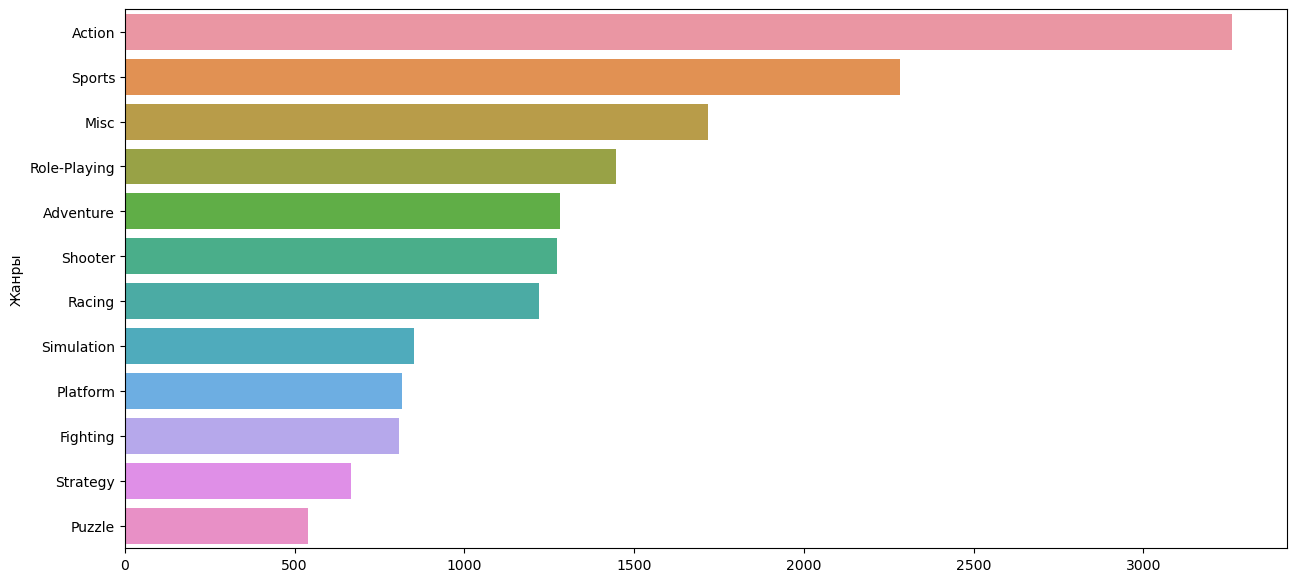

In [39]:
plt.figure(figsize=(15, 7))
sns.barplot(data=data.genre.value_counts().to_frame().reset_index(), x='genre', y='index')
plt.xlabel('')
plt.ylabel('Жанры');

Никаких проблем с данными в этом столбце не наблюдается.

### Столбец na_sales

In [40]:
data.na_sales.describe(percentiles=[0.01, 0.25, .5, .75, .90, .99]).apply('{0:.2f}'.format)

count    16163.00
mean         0.25
std          0.71
min          0.00
1%           0.00
25%          0.00
50%          0.08
75%          0.23
90%          0.59
99%          2.71
max         41.36
Name: na_sales, dtype: object

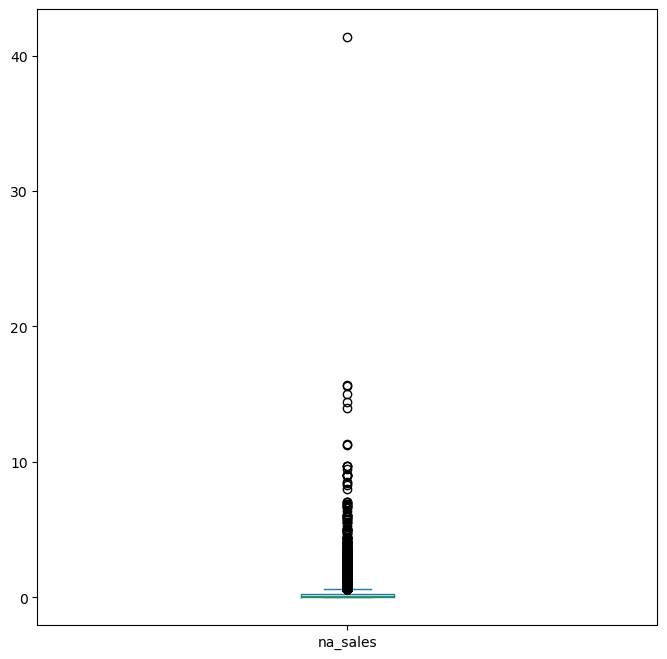

In [41]:
data.na_sales.plot(kind='box', figsize=(8, 8));

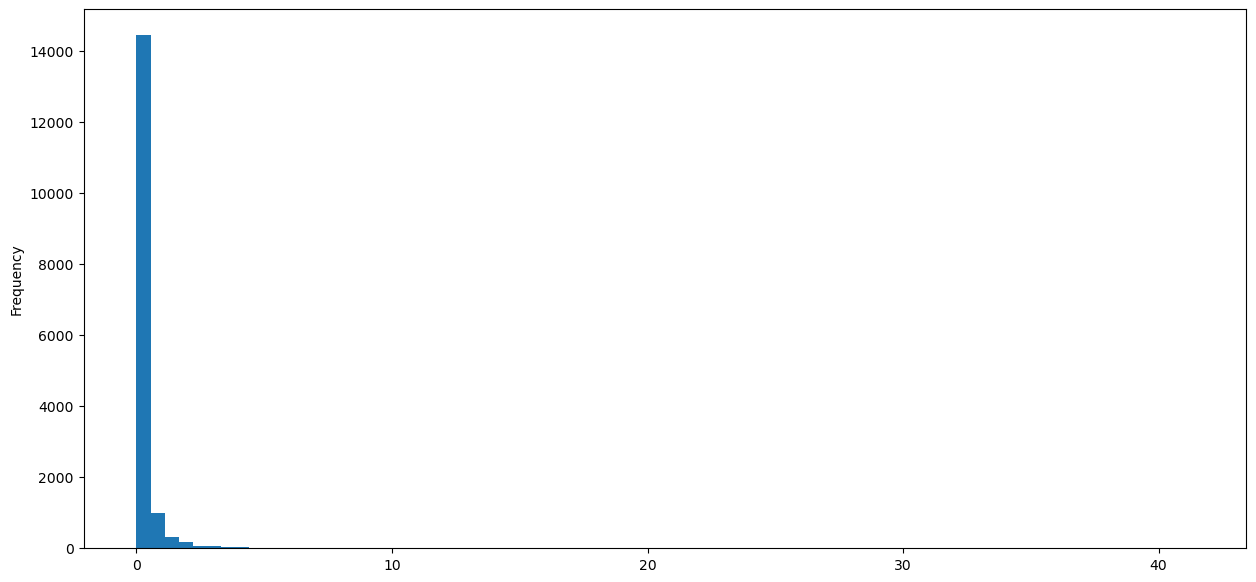

In [42]:
data.na_sales.plot(kind='hist', bins=75, figsize=(15, 7));

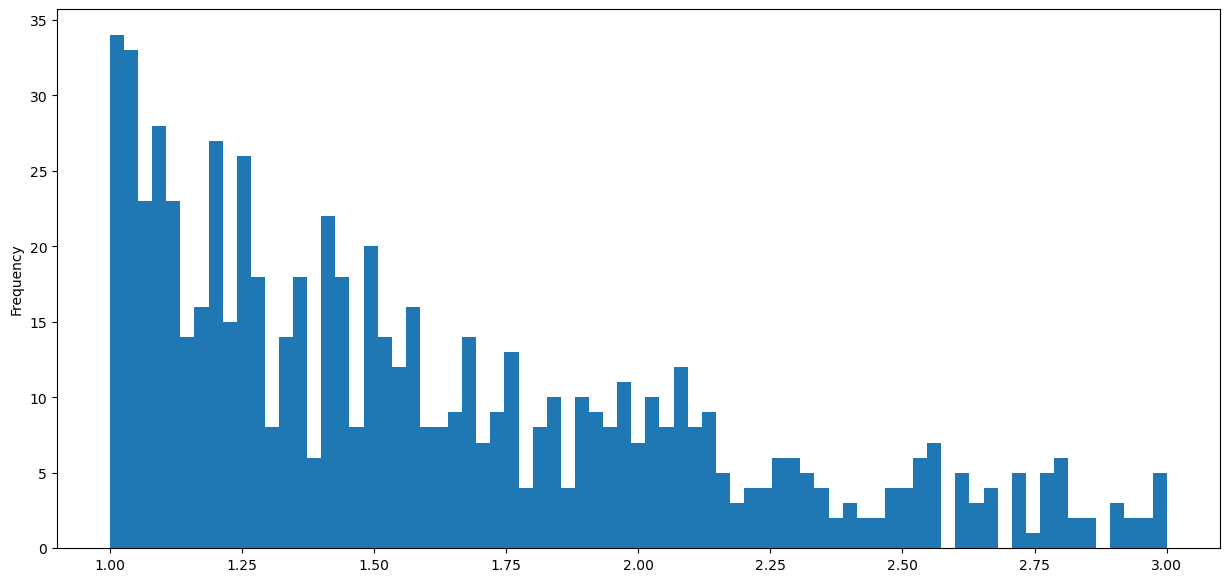

In [43]:
data.na_sales.plot(kind='hist', bins=75, figsize=(15, 7), range=(1, 3));

Значения более 2.71 встречаются крайне редко и они сльно исказят общую картину, их стоит убрать.

Большая часть значений расположена в районе 0. Их стоит отредактировать в будущем, через сумму общей выручки игр.

In [44]:
data = data[data.na_sales < 2.71]

Было удалено 159 строк.

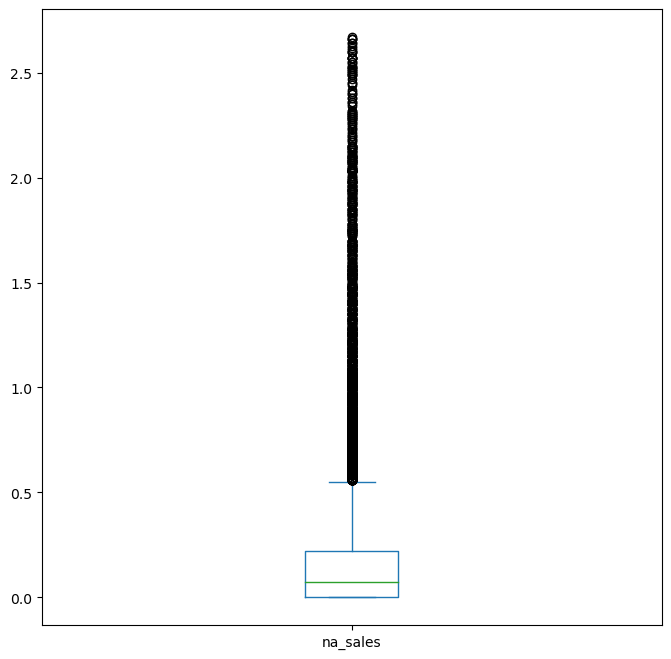

In [45]:
data.na_sales.plot(kind='box', figsize=(8, 8));

### Столбец eu_sales

In [46]:
data.eu_sales.describe(percentiles=[0.01, 0.25, .5, .75, .90, .99, .995]).apply('{0:.2f}'.format)

count    16000.00
mean         0.12
std          0.29
min          0.00
1%           0.00
25%          0.00
50%          0.02
75%          0.10
90%          0.32
99%          1.33
99.5%        1.82
max          6.42
Name: eu_sales, dtype: object

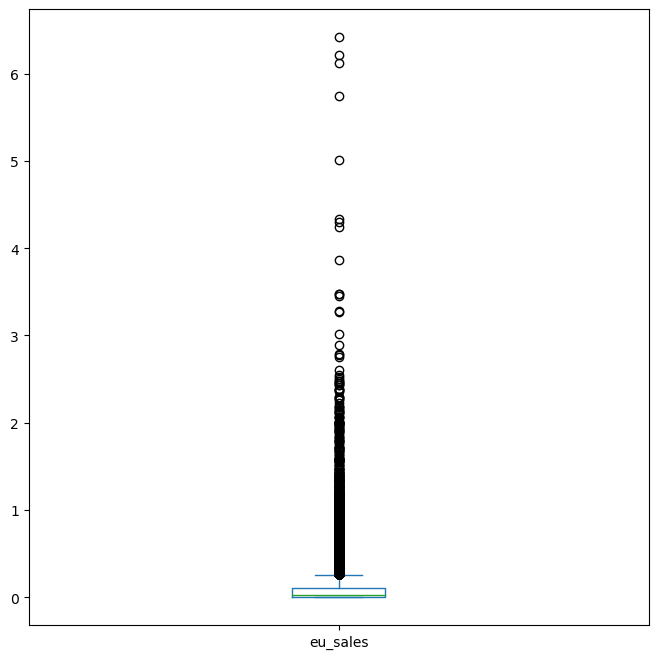

In [47]:
data.eu_sales.plot(kind='box', figsize=(8, 8));

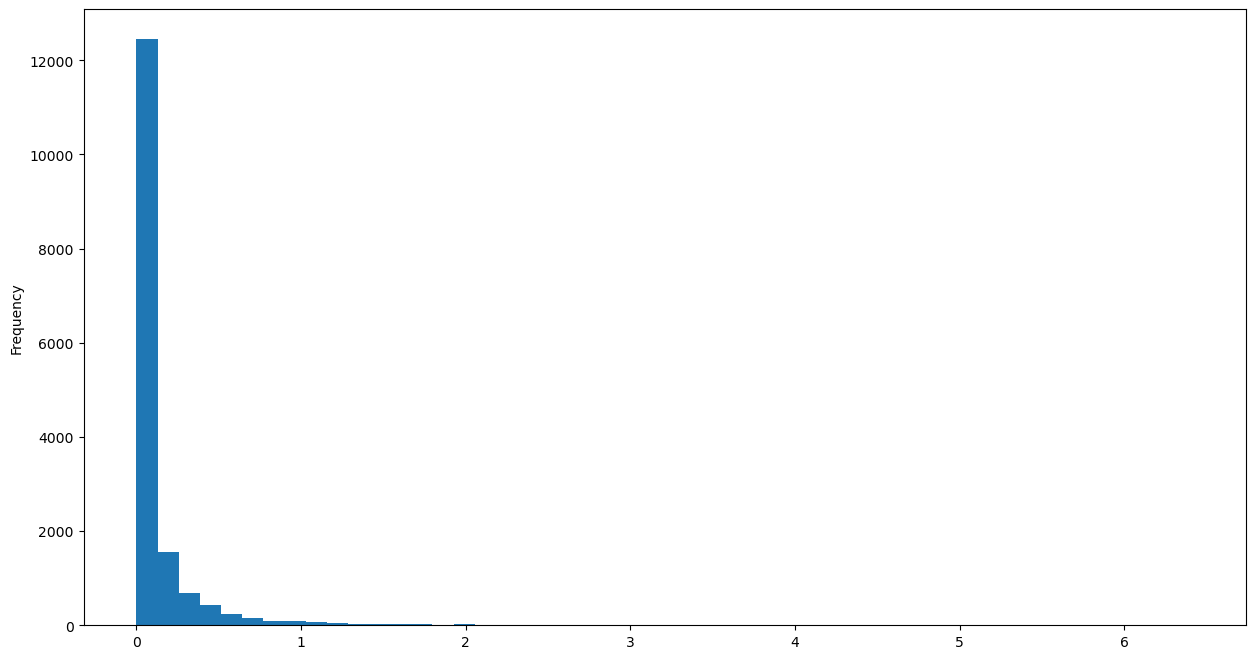

In [48]:
data.eu_sales.plot(kind='hist', figsize=(15, 8), bins=50);

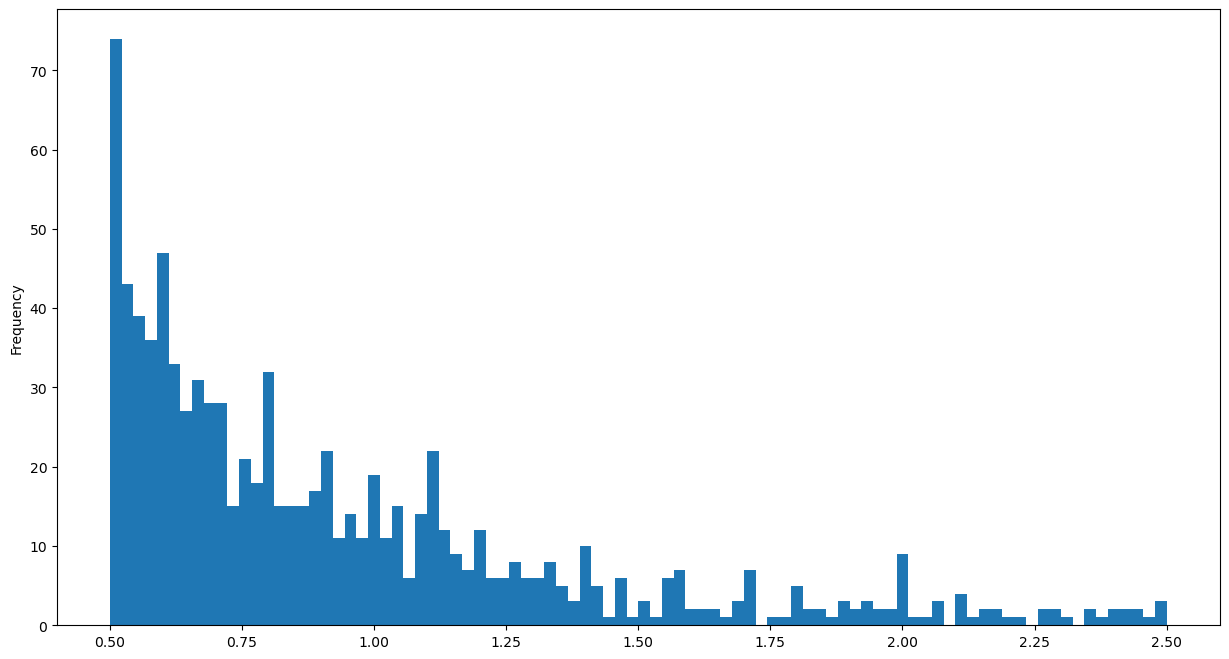

In [49]:
data.eu_sales.plot(kind='hist', figsize=(15, 8), bins=90, range=(0.5, 2.5));

Значения более 1.82 встречаются в 0.5% случаев и очень сильно исказят наши средние данные. Уберём их.

In [50]:
data = data[data.eu_sales < 1.82]

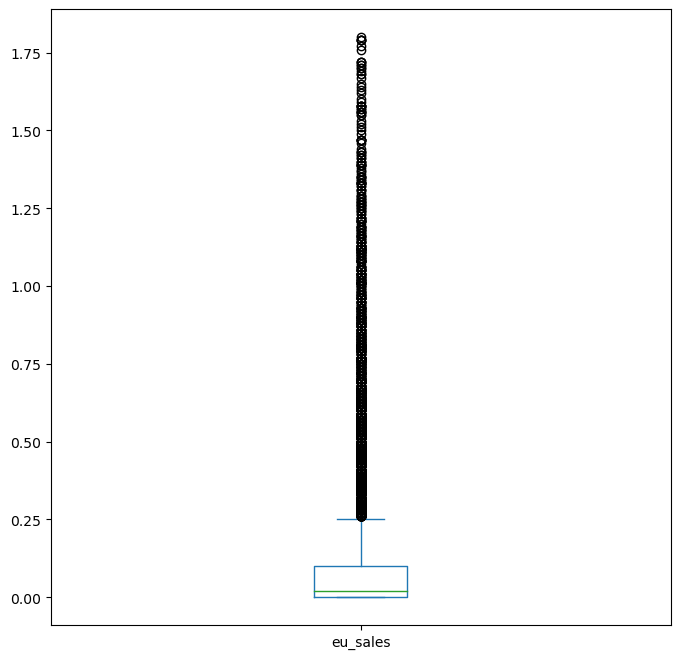

In [51]:
data.eu_sales.plot(kind='box', figsize=(8, 8));

### Столбец jp_sales

In [52]:
data.jp_sales.describe(percentiles=[0.01, 0.25, .5, .75, .90, .99, .995]).apply('{0:.2f}'.format)

count    15918.00
mean         0.06
std          0.19
min          0.00
1%           0.00
25%          0.00
50%          0.00
75%          0.03
90%          0.14
99%          0.83
99.5%        1.13
max          4.87
Name: jp_sales, dtype: object

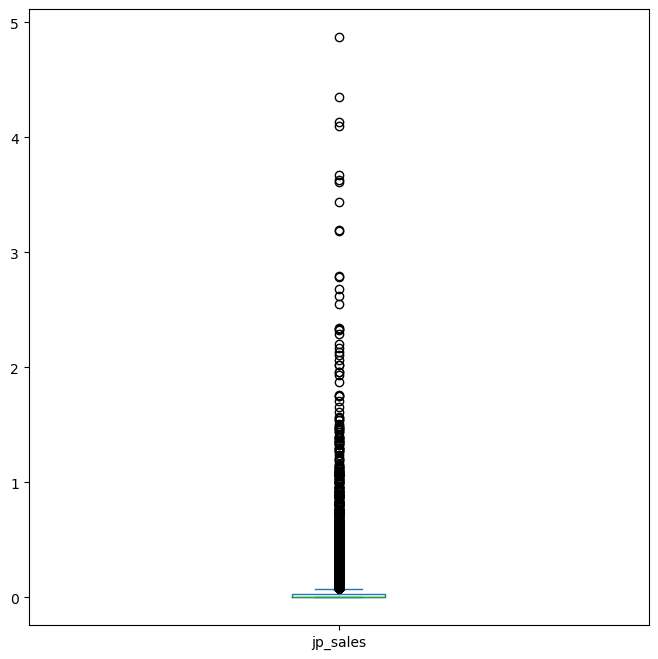

In [53]:
data.jp_sales.plot(kind='box', figsize=(8, 8));

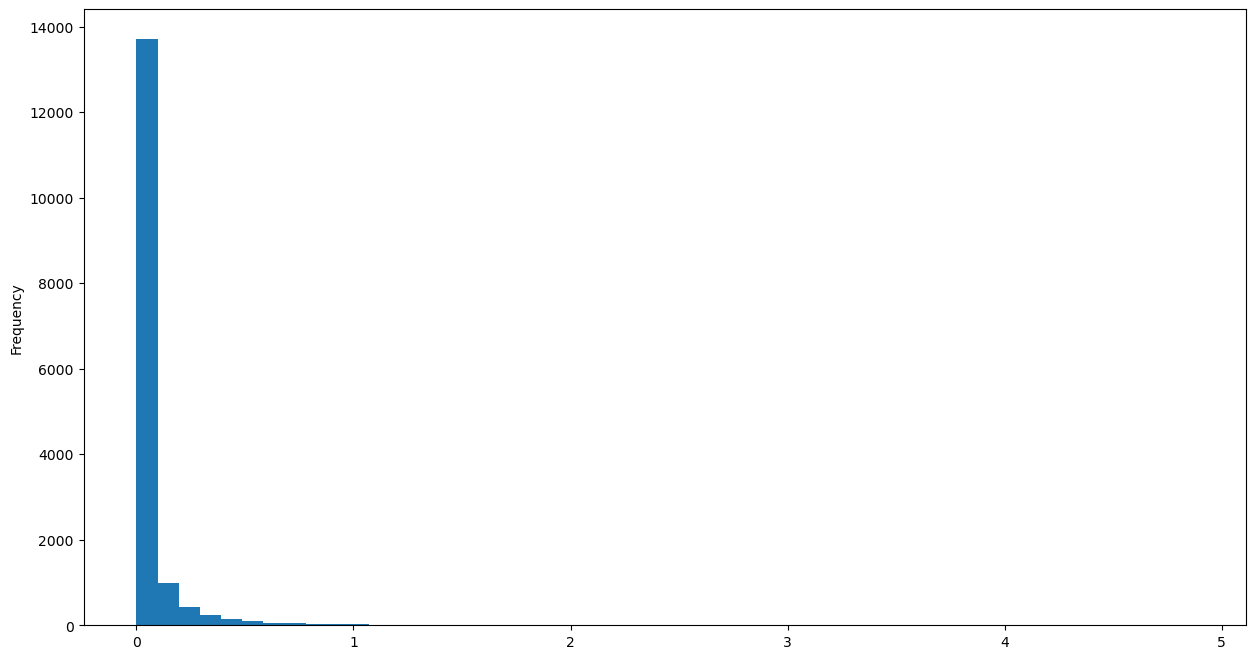

In [54]:
data.jp_sales.plot(kind='hist', figsize=(15, 8), bins=50);

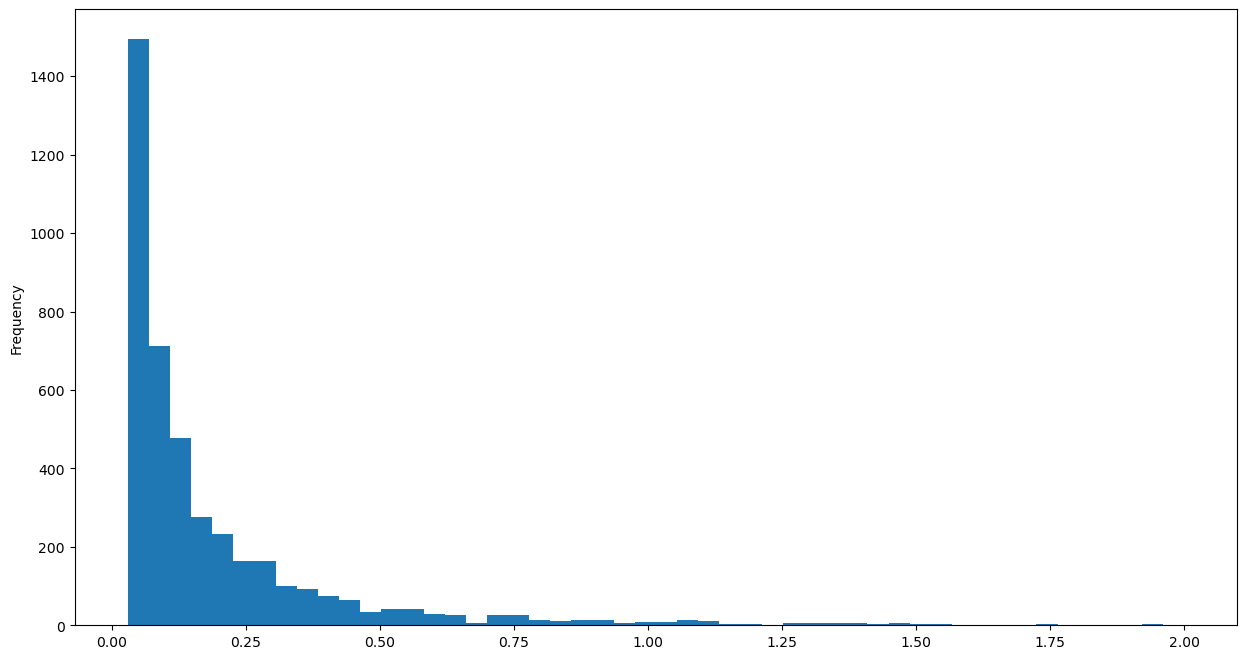

In [55]:
data.jp_sales.plot(kind='hist', figsize=(15, 8), bins=50, range=(0.03, 2));

In [56]:
data[data.jp_sales > 1.13]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
88,final fantasy viii,PS,1999,Role-Playing,2.28,1.72,3.63,0.23,90.0,8.6,T
131,pokémon emerald version,GBA,2004,Role-Playing,2.57,1.58,2.06,0.21,76.0,9,E
133,pokémon crystal version,GB,2000,Role-Playing,2.55,1.56,1.29,0.99,NaN,NaN,NaN
148,final fantasy xii,PS2,2006,Role-Playing,1.88,0.00,2.33,1.74,92.0,7.6,T
151,resident evil 2,PS,1998,Action,1.88,1.47,2.02,0.45,89.0,9.2,M
...,...,...,...,...,...,...,...,...,...,...,...
1466,yokai watch 3,3DS,2016,Action,0.00,0.00,1.33,0.00,NaN,NaN,NaN
1512,romancing saga 3,SNES,1995,Role-Playing,0.00,0.00,1.29,0.01,NaN,NaN,NaN
1644,chocobo no fushigi dungeon,PS,1997,Role-Playing,0.00,0.00,1.14,0.08,NaN,NaN,NaN
1662,dragon quest iv: michibikareshi monotachi,PS,2001,Role-Playing,0.00,0.00,1.20,0.01,NaN,NaN,NaN


Значения более 1.13 представляют собой 0.5%  наших данных и значительно искажают среднее их представление, их стоит удалить.

In [57]:
data = data[data.jp_sales < 1.13]

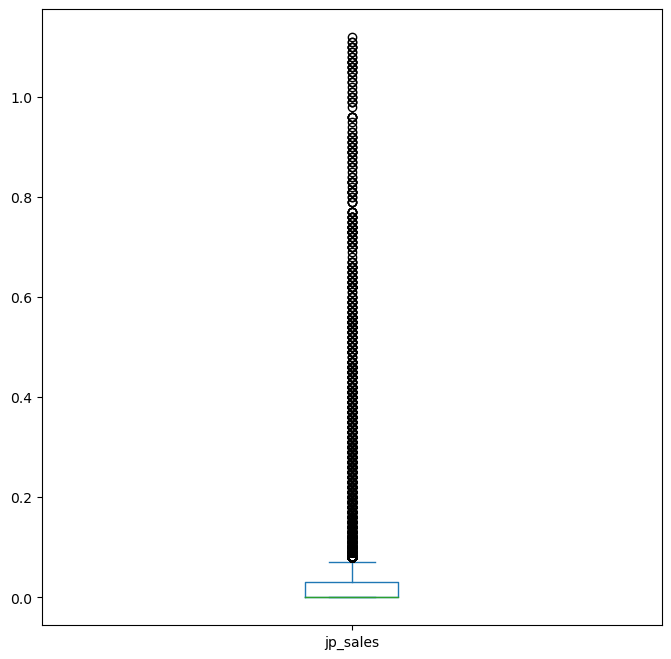

In [58]:
data.jp_sales.plot(kind='box', figsize=(8, 8));

### Столбец other_sales

In [59]:
data.other_sales.describe(percentiles=[0.01, 0.25, .5, .75, .90, .99, .995]).apply('{0:.2f}'.format)

count    15837.00
mean         0.04
std          0.09
min          0.00
1%           0.00
25%          0.00
50%          0.01
75%          0.03
90%          0.09
99%          0.36
99.5%        0.47
max          2.93
Name: other_sales, dtype: object

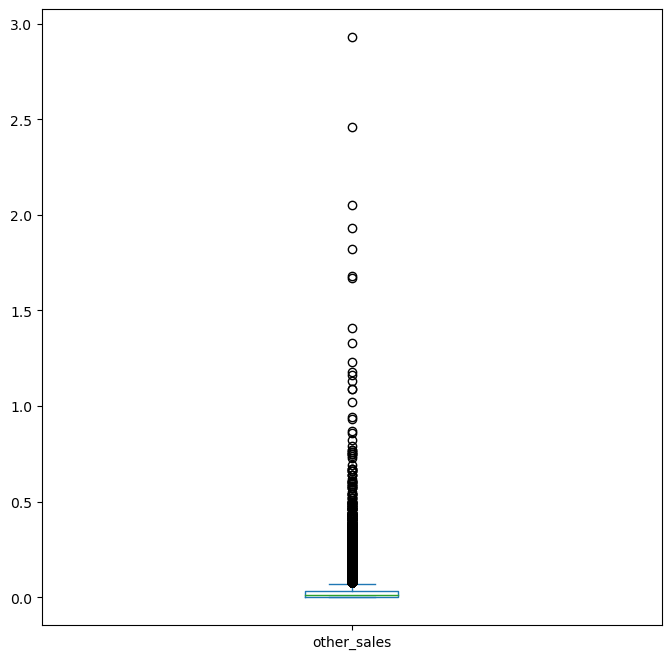

In [60]:
data.other_sales.plot(kind='box', figsize=(8, 8));

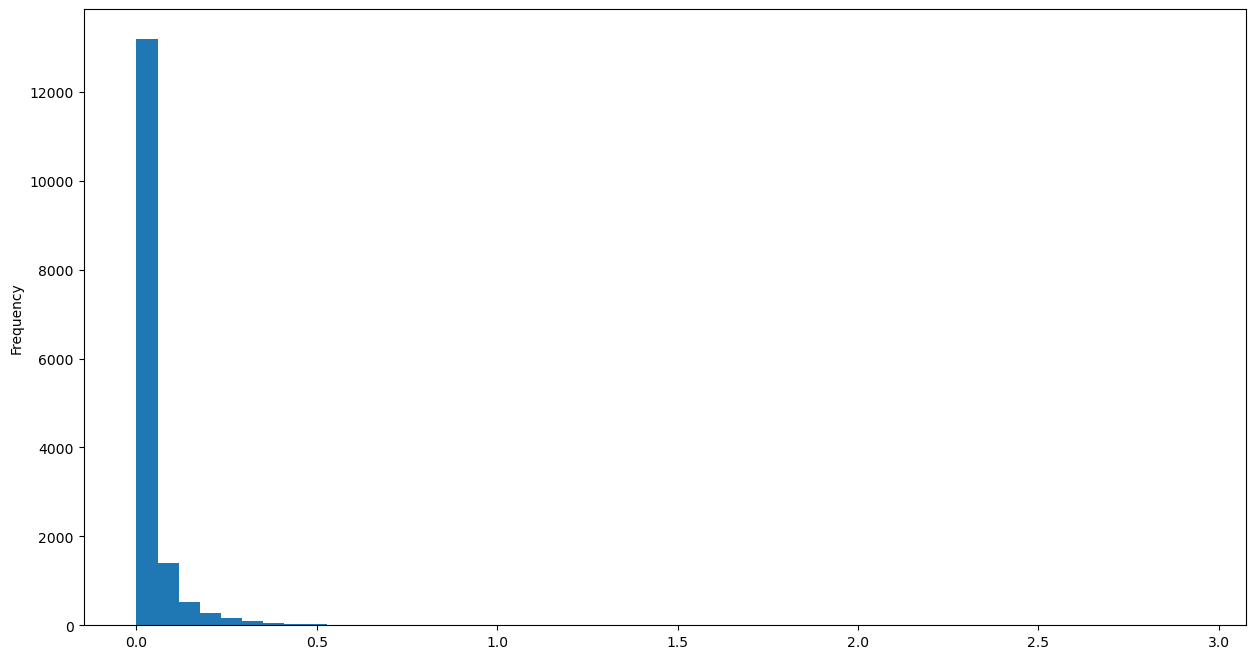

In [61]:
data.other_sales.plot(kind='hist', figsize=(15, 8), bins=50);

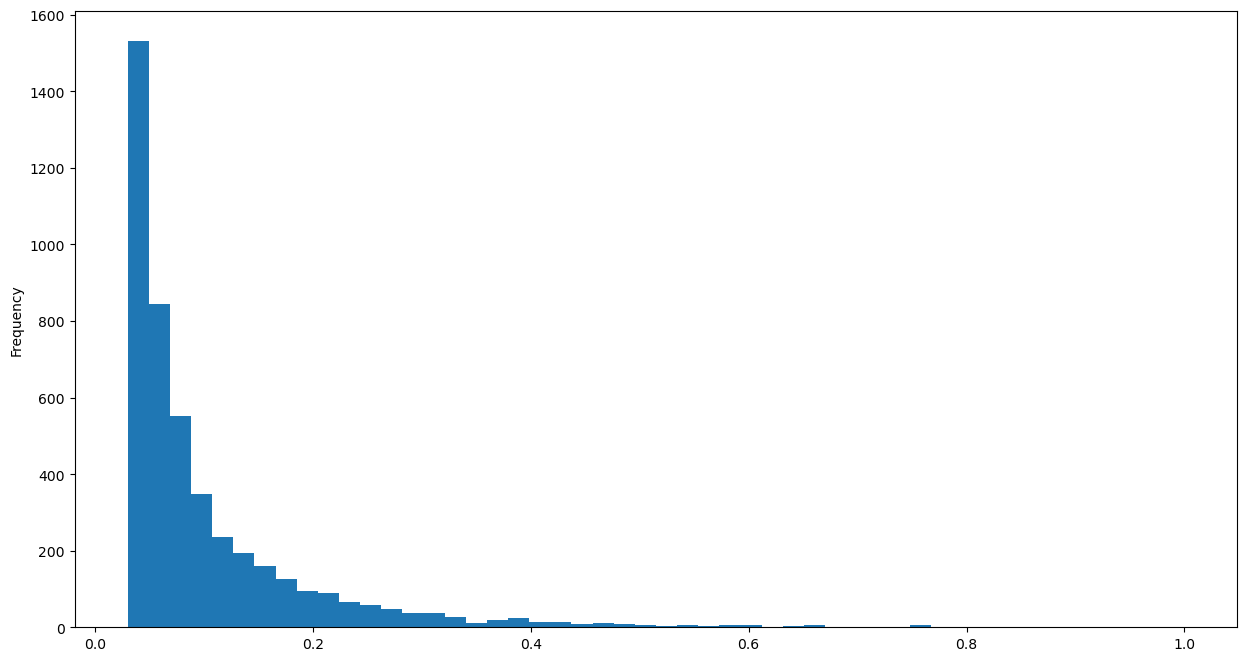

In [62]:
data.other_sales.plot(kind='hist', figsize=(15, 8), bins=50, range=(0.03, 1));

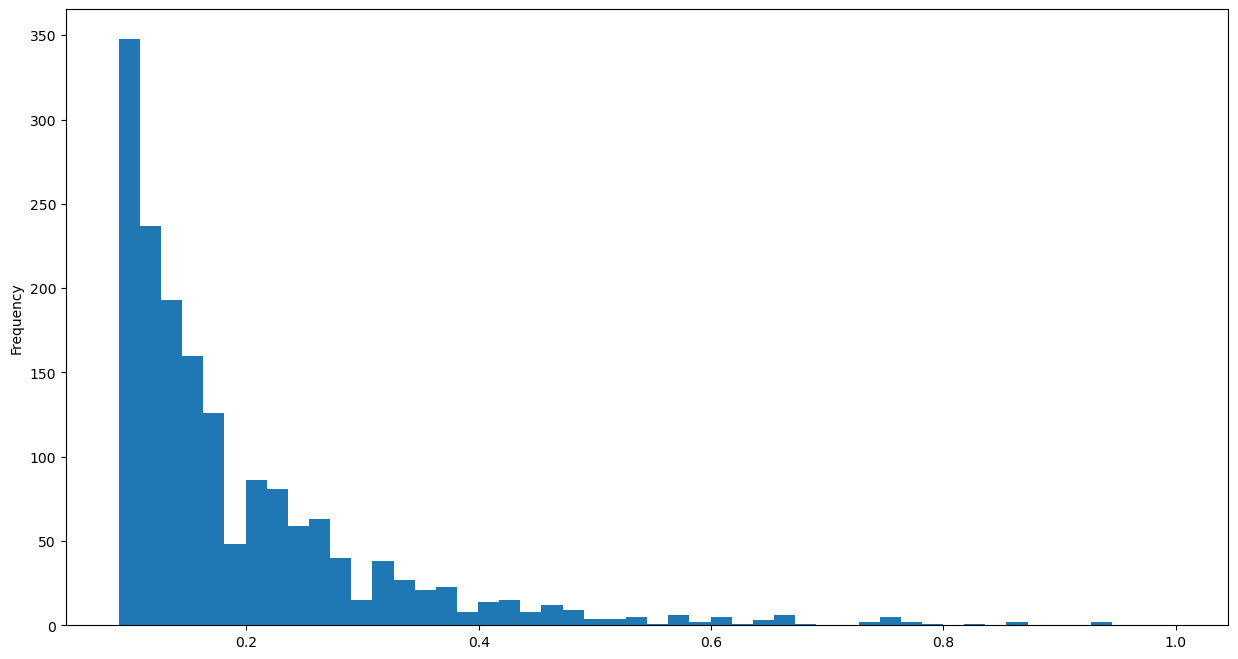

In [63]:
data.other_sales.plot(kind='hist', figsize=(15, 8), bins=50, range=(0.09, 1));

In [64]:
data[data.other_sales > 0.37]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
147,metal gear solid 4: guns of the patriots,PS3,2008,Action,2.63,1.71,0.83,0.82,94.0,8.7,M
199,resident evil 5,PS3,2009,Action,1.96,1.41,1.08,0.64,84.0,7.5,M
200,the legend of zelda: phantom hourglass,DS,2007,Action,1.85,1.80,0.95,0.48,90.0,8,E
203,resident evil,PS,1996,Action,2.05,1.16,1.11,0.73,91.0,9,M
212,uncharted: drake's fortune,PS3,2007,Action,2.31,1.72,0.12,0.77,88.0,8.1,T
...,...,...,...,...,...,...,...,...,...,...,...
3505,the sims 3: world adventures,PC,2009,Simulation,0.02,0.18,0.00,0.38,81.0,8,T
3681,singstar summer party,PS2,2008,Misc,0.00,0.06,0.00,0.48,NaN,NaN,NaN
3826,the golden compass,PS2,2007,Action,0.13,0.00,0.00,0.39,46.0,5.2,E10+
4343,singstar take that,PS2,2009,Misc,0.00,0.06,0.00,0.39,NaN,NaN,NaN


Значения более 0.37 представляют собой 1%  наших данных и значительно искажают среднее их представление, их стоит удалить.

In [65]:
data = data[data.other_sales < 0.37]

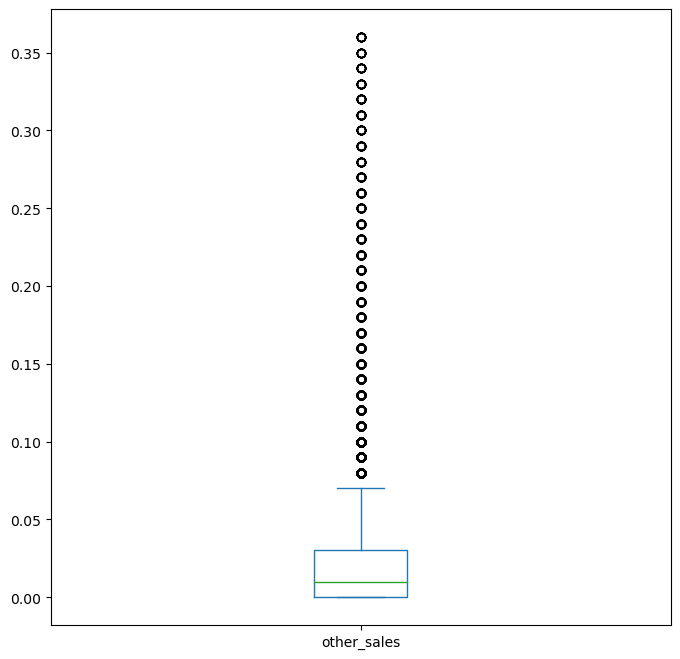

In [66]:
data.other_sales.plot(kind='box', figsize=(8, 8));

### Столбец critic_score

In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15679 entries, 166 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             15679 non-null  object 
 1   platform         15679 non-null  object 
 2   year_of_release  15679 non-null  int64  
 3   genre            15679 non-null  object 
 4   na_sales         15679 non-null  float64
 5   eu_sales         15679 non-null  float64
 6   jp_sales         15679 non-null  float64
 7   other_sales      15679 non-null  float64
 8   critic_score     7735 non-null   float64
 9   user_score       9581 non-null   object 
 10  rating           9513 non-null   object 
dtypes: float64(5), int64(1), object(5)
memory usage: 1.4+ MB


In [68]:
data.critic_score.unique()

array([93., 88., 96., 86., 77., nan, 91., 84., 85., 59., 79., 94., 82.,
       90., 78., 89., 72., 83., 92., 71., 68., 76., 75., 87., 80., 63.,
       62., 73., 81., 67., 74., 61., 97., 69., 95., 50., 25., 70., 66.,
       42., 44., 64., 49., 55., 48., 56., 57., 29., 47., 65., 54., 20.,
       53., 37., 38., 58., 33., 52., 60., 30., 32., 45., 43., 51., 40.,
       46., 39., 34., 35., 41., 36., 28., 31., 27., 98., 26., 19., 23.,
       24., 21., 17., 13.])

Значения в этом столбце стоит привести к десятибальной системе оценок как и у user_score.

In [69]:
data['critic_score'] = data.critic_score.apply(lambda val: val / 10)

Построим графики количества выпущенных игр за год и то же количество, но без оценок критиков.

In [70]:
year_df_count = data[data.critic_score.isna()].groupby('year_of_release').agg({'name' : 'count'})

In [71]:
total_year_df_count = data.groupby('year_of_release').agg({'name' : 'count'})


In [72]:
total_year_df_count['without_critic'] = year_df_count['name']

In [73]:
total_year_df_count.columns = ['total', 'no_critic']

In [74]:
total_year_df_count['ratio'] = round(total_year_df_count.no_critic / total_year_df_count.total, 2)

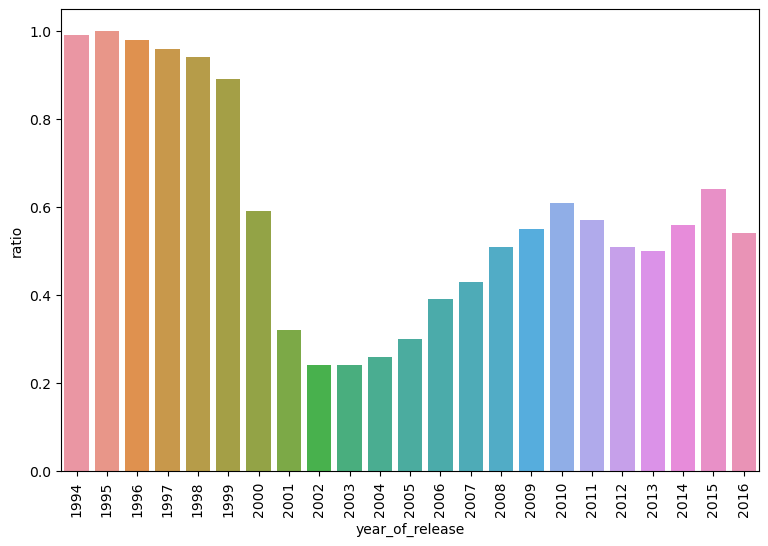

In [75]:
plt.figure(figsize=(9, 6))
sns.barplot(data=total_year_df_count, x=total_year_df_count.index, y='ratio')
plt.xticks(rotation=90);

Изучим пропущенные данные в этом столбце.

Пропущенные данные могут быть связаны с несколькими факторами: Критики просто не ставили оценку этим играм, либо же была ошибка считывания данных.

Имеет смысл посмотреть на пересечения оценок критиков и игроков, и заполнять значения там, где отсутствет только 1 столбец (или оценка критиков или оценка игрока).

In [76]:
data[(data.critic_score.isna()) ^ (data.user_score.isna())]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
359,just dance 2014,Wii,2013,Misc,1.88,1.39,0.00,0.31,NaN,6.2,E10+
437,club penguin: elite penguin force,DS,2008,Adventure,1.87,0.97,0.00,0.30,NaN,8,E
440,need for speed iii: hot pursuit,PS,1998,Racing,2.14,0.86,0.00,0.13,8.8,NaN,E
505,imagine: babyz,DS,2007,Simulation,1.30,1.26,0.00,0.31,NaN,7.7,E
519,finding nemo,GBA,2003,Action,1.59,1.05,0.04,0.14,NaN,7,E
...,...,...,...,...,...,...,...,...,...,...,...
16672,metal gear solid v: the definitive experience,XOne,2016,Action,0.01,0.00,0.00,0.00,NaN,tbd,M
16681,worms 2,PC,1997,Strategy,0.00,0.01,0.00,0.00,NaN,8.1,K-A
16688,outdoors unleashed: africa 3d,3DS,2011,Sports,0.01,0.00,0.00,0.00,NaN,tbd,T
16704,plushees,DS,2008,Simulation,0.01,0.00,0.00,0.00,NaN,tbd,E


Есть 1920 строк, удовлетворяющих этому условию, но чтобы начать заполнять значения, необходимо разобраться со значениями tbd в user_score и просмотреть столбец rating повнимательнее.

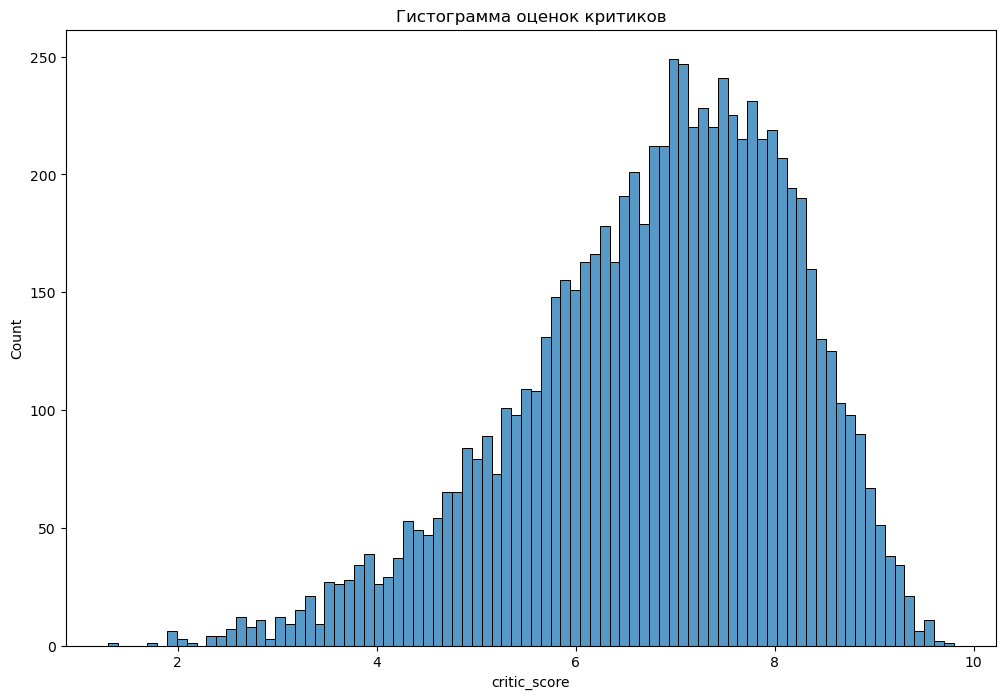

In [77]:
plt.figure(figsize=(12, 8))
sns.histplot(data.critic_score, bins=data.critic_score.nunique() + 5)
plt.title('Гистограмма оценок критиков');

Аномальных значений не наблюдается.

### Столбец user_score

In [78]:
data.user_score.unique()

array(['8.3', '9', '8.9', '8.4', '7.9', nan, '8.1', '8.5', '4', '7.5',
       '8', '8.8', '8.7', '7.6', '6.2', '4.1', '5.6', '8.6', '8.2', '5.5',
       '7.8', '9.2', '4.6', '7.2', '9.1', '6.8', '7.4', '5.8', '7', '6.6',
       '6.4', '7.3', '4.3', '5.3', '7.7', '6.1', '9.3', 'tbd', '6.7',
       '6.5', '5.9', '5.7', '6.3', '4.9', '5.4', '3.1', '6.9', '2.9',
       '7.1', '9.4', '5.2', '5', '6', '3.3', '4.7', '4.4', '4.5', '4.8',
       '5.1', '3.5', '2.5', '1.9', '3', '4.2', '2.7', '2.2', '2', '9.5',
       '3.4', '2.1', '3.6', '2.8', '3.2', '1.8', '3.8', '0', '1.6', '9.6',
       '3.7', '3.9', '2.4', '1.7', '1.1', '0.3', '1.5', '2.6', '0.7',
       '1.2', '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [79]:
data.user_score.value_counts().head(20)

tbd    2390
7.8     311
8       271
8.2     266
8.3     243
8.5     239
7.5     236
7.9     232
8.1     229
7.3     227
7.7     223
7       216
8.4     209
7.4     204
7.6     202
8.6     191
6.8     190
7.1     175
8.8     174
8.7     167
Name: user_score, dtype: int64

In [80]:
user_score_values = data[data.user_score != 'tbd']
user_score_values

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
166,mario kart: super circuit,GBA,2001,Racing,2.62,1.64,0.99,0.23,9.3,8.3,E
221,crash team racing,PS,1999,Racing,2.57,1.57,0.44,0.21,8.8,9,E
233,the legend of zelda: the wind waker,GC,2002,Action,2.60,0.99,0.89,0.13,9.6,8.9,E
235,luigi's mansion: dark moon,3DS,2013,Action,1.80,1.39,1.11,0.29,8.6,8.4,E
248,nintendo land,WiiU,2012,Misc,2.52,1.11,0.46,0.33,7.7,7.9,E10+
...,...,...,...,...,...,...,...,...,...,...,...
16710,samurai warriors: sanada maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,lma manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,haitaka no psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,spirits spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [81]:
user_score_values['user_score'] = user_score_values['user_score'].astype('float')

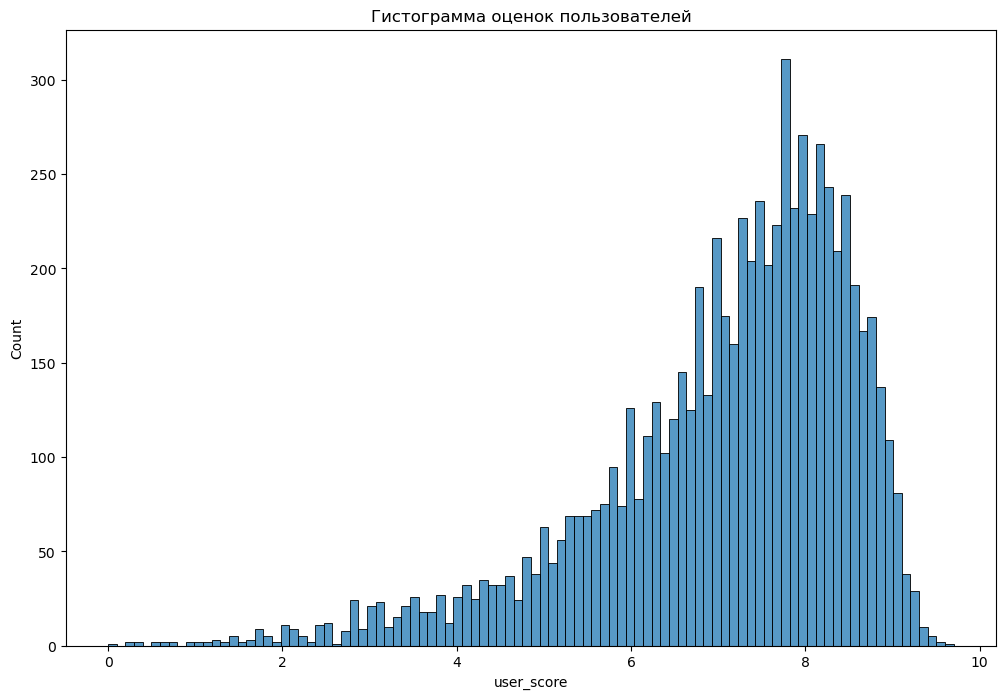

In [82]:
plt.figure(figsize=(12, 8))
sns.histplot(user_score_values.user_score, bins=user_score_values.user_score.nunique() + 3)
plt.title('Гистограмма оценок пользователей');

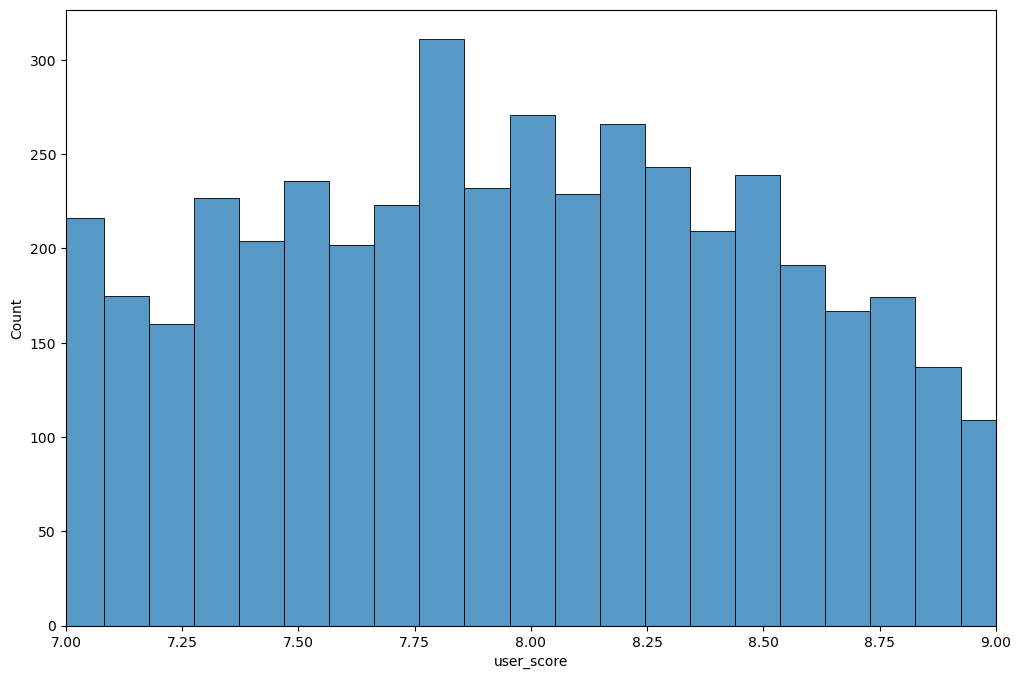

In [83]:
plt.figure(figsize=(12, 8))
sns.histplot(user_score_values.user_score, bins=100)
plt.xlim(7, 9);

Анамальных значений не наблюдается. По сравнению с гистограммой оценок критиков, обычные пользователи менее охотно ставят низние оценки, из-за чего гистограмма смещена вправо.

Значение tbd - To Be Determined, переводится как "оценка будет определена", означает, что за игру голосовали и играли в нее, но по неизвестым причинам оценка еще не опубликована. Причины этого могут быть: недостаточное количество оценок, издатель попросил не публиковать оценки игроков до опеределенной даты.

Фактически это отсутсвтующие значения, их стоит перевести в категорию nan и обрабатывать так же, как и обычные пропущенные значения - если есть оценка критиков, то значения будет заполняться.

In [84]:
data['user_score'].replace('tbd', np.nan, inplace=True)

Заодно изменим тип столбца в float

In [85]:
data['user_score'] = data['user_score'].astype('float')

In [86]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
166,mario kart: super circuit,GBA,2001,Racing,2.62,1.64,0.99,0.23,9.3,8.3,E
221,crash team racing,PS,1999,Racing,2.57,1.57,0.44,0.21,8.8,9.0,E
233,the legend of zelda: the wind waker,GC,2002,Action,2.60,0.99,0.89,0.13,9.6,8.9,E
235,luigi's mansion: dark moon,3DS,2013,Action,1.80,1.39,1.11,0.29,8.6,8.4,E
248,nintendo land,WiiU,2012,Misc,2.52,1.11,0.46,0.33,7.7,7.9,E10+


### Столбец rating

In [87]:
data.rating.unique()

array(['E', 'E10+', nan, 'T', 'M', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [88]:
raiting_groups = data.groupby('rating').agg({'name' : 'count'}).sort_values(by='name', ascending=False)

In [89]:
raiting_groups

,name
rating,
E,3840
T,2841
M,1439
E10+,1380
EC,8
K-A,2
RP,2
AO,1


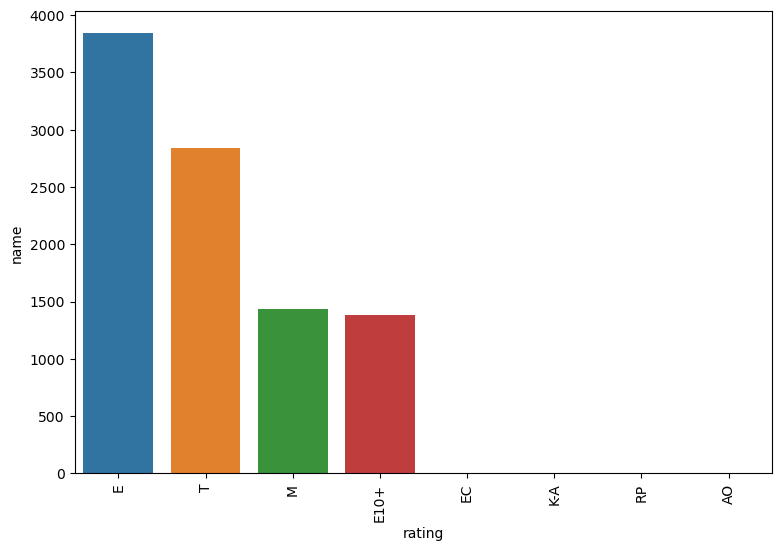

In [90]:
plt.figure(figsize=(9, 6))
sns.barplot(data=raiting_groups, x=raiting_groups.index, y='name')
plt.xticks(rotation=90);

Значения рейтигоа ЕС, К-А, RP, AO исчезающе малы, их стоит убрать из наших данных.

In [91]:
data = data[~data.rating.isin(raiting_groups.name.tail(4).index)]

Сами пропущенные значения в этом столбце заменять ничем не буду. Объяснить сборы частично через рейтинг можно, но заполняя пропущенные значения через цену и оценки скорее добавит ложной корреляции к рейтингу. 

### Создание и обработка столбца total_sales

In [92]:
data['total_sales'] = data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

In [93]:
data.total_sales.describe(percentiles=[0.01, 0.25, .5, .75, .90, .99, .995]).apply('{0:.2f}'.format)

count    15666.00
mean         0.35
std          0.52
min          0.00
1%           0.01
25%          0.06
50%          0.15
75%          0.41
90%          0.93
99%          2.62
99.5%        3.10
max          5.48
Name: total_sales, dtype: object

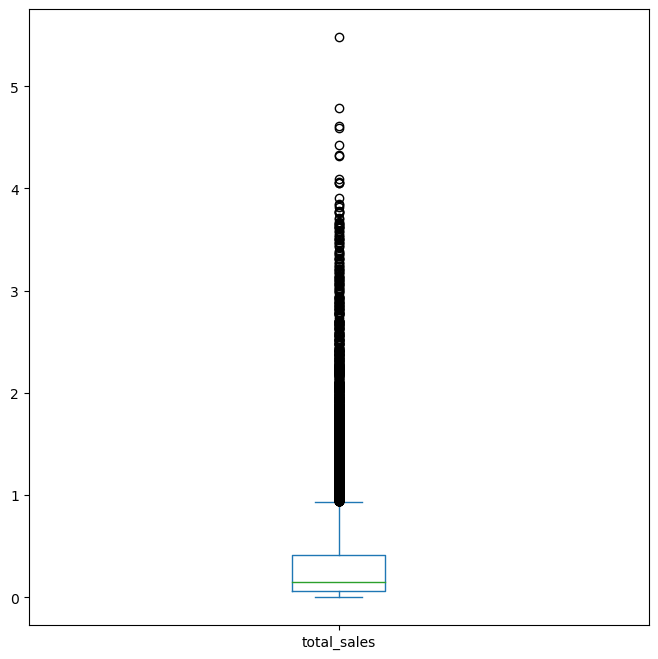

In [94]:
data.total_sales.plot(kind='box', figsize=(8, 8));

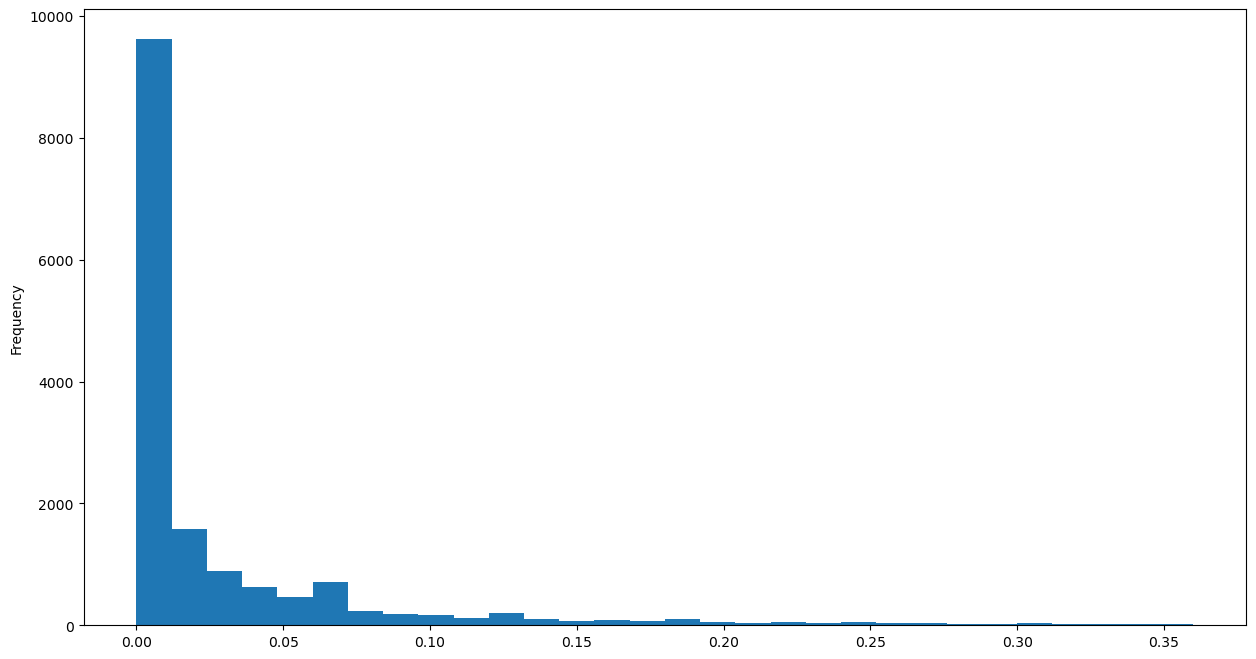

In [95]:
data.other_sales.plot(kind='hist', figsize=(15, 8), bins=30);

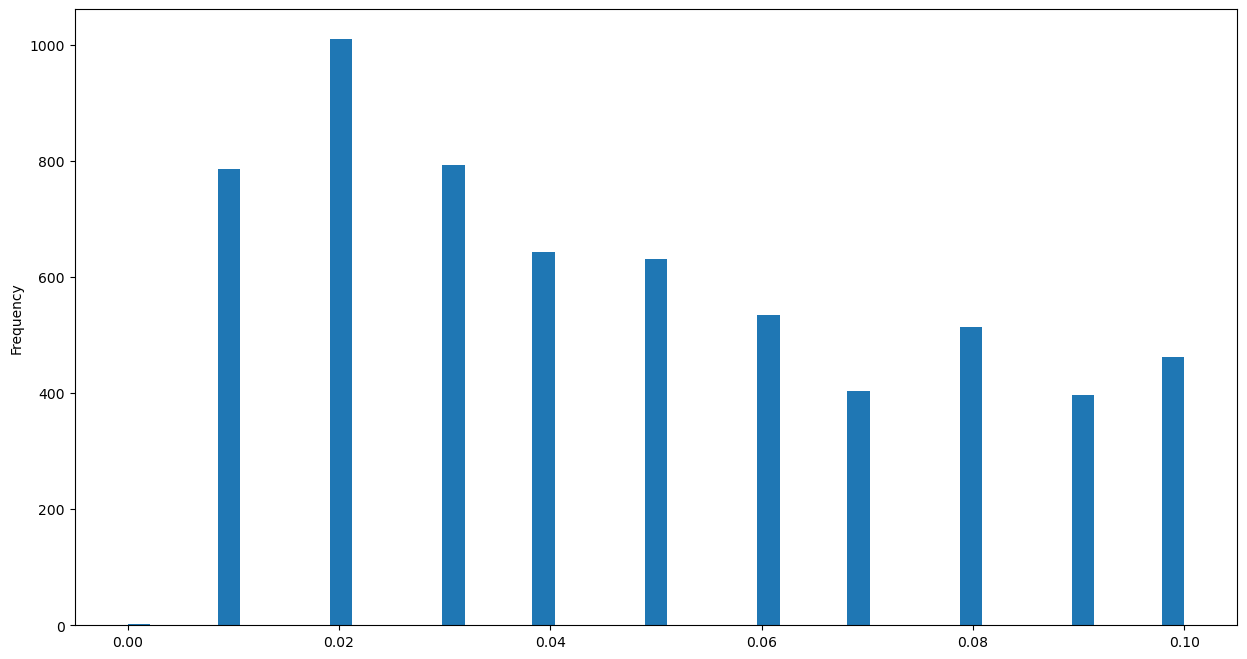

In [96]:
data.total_sales.plot(kind='hist', figsize=(15, 8), bins=47, range=(0, 0.1));

Значения до 0.01 миллиона можно выбросить, т.к. значения с нулями по всем остальным продажам.

In [97]:
data[data.total_sales <= 0.01]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15384,order of war,PC,2009,Strategy,0.00,0.01,0.00,0.0,6.9,7.3,T,0.01
15486,arslan: the warriors of legend,XOne,2016,Action,0.01,0.00,0.00,0.0,NaN,5.8,T,0.01
15499,motocross mania 3,XB,2005,Racing,0.01,0.00,0.00,0.0,3.8,3.6,T,0.01
15520,pump it up: exceed,XB,2005,Misc,0.01,0.00,0.00,0.0,7.4,7.5,T,0.01
15542,digimon rumble arena 2,XB,2004,Fighting,0.01,0.00,0.00,0.0,6.5,8.8,T,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,samurai warriors: sanada maru,PS3,2016,Action,0.00,0.00,0.01,0.0,NaN,NaN,NaN,0.01
16711,lma manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.0,NaN,NaN,NaN,0.01
16712,haitaka no psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.0,NaN,NaN,NaN,0.01
16713,spirits spells,GBA,2003,Platform,0.01,0.00,0.00,0.0,NaN,NaN,NaN,0.01


In [98]:
data = data[data.total_sales >= 0.01]

### Заполнение пропущенных значений в user_score

In [99]:
data[(data.user_score.isna()) & ~(data.critic_score.isna())]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
440,need for speed iii: hot pursuit,PS,1998,Racing,2.14,0.86,0.00,0.13,8.8,NaN,E,3.13
637,riven: the sequel to myst,PC,1997,Adventure,1.52,0.82,0.00,0.10,8.3,NaN,E,2.44
645,udraw studio,Wii,2010,Misc,1.65,0.57,0.00,0.20,7.1,NaN,E,2.42
821,the incredibles,GBA,2004,Action,1.15,0.77,0.04,0.10,5.5,NaN,E,2.06
1047,tetris worlds,GBA,2001,Puzzle,1.25,0.39,0.00,0.06,6.5,NaN,E,1.70
...,...,...,...,...,...,...,...,...,...,...,...,...
16577,space raiders,GC,2003,Shooter,0.01,0.00,0.00,0.00,4.0,NaN,T,0.01
16669,super robot taisen: original generation,GBA,2002,Role-Playing,0.01,0.00,0.00,0.00,7.2,NaN,T,0.01
16695,planet monsters,GBA,2001,Action,0.01,0.00,0.00,0.00,6.7,NaN,E,0.01
16697,bust-a-move 3000,GC,2003,Puzzle,0.01,0.00,0.00,0.00,5.3,NaN,E,0.01


Создадим столбец с разницей оценок критиков и оценок юзеров

In [100]:
data['diff_score'] = data['critic_score'] - data['user_score']

Пройдёмся циклом по строкам с пропущенными значениями в оценках критиков, но имеющих оценки пользователей.

Для каждой такой строки, выбираем значения по жанру, платформе, возрастному рейтингу и продажам.

По этой маске ищем похожие оценки в промежутке 0.4 от разницы оценок

In [101]:
%%time
data['value_category'] = 'black'
for index in data[(data.user_score.isna()) & ~(data.critic_score.isna())].index:
    genre_local = data.loc[index, 'genre']
    platform_local = data.loc[index, 'platform']
    rating_local = data.loc[index, 'rating']
    sales_local = data.loc[index, 'total_sales']
    
    mask = ((data.genre == genre_local) & 
        (data.platform == platform_local) &
        (data.rating == rating_local) &
        (data.total_sales.between(sales_local - 0.2, sales_local + 0.2)))
    data.loc[index, 'user_score'] = data[mask].user_score.mean() + data[mask].diff_score.mean()
    data.loc[index, 'value_category'] = 'red'

Wall time: 2.94 s


Построим диаграмма рассеяния для визуального анализа качества заполнения данных

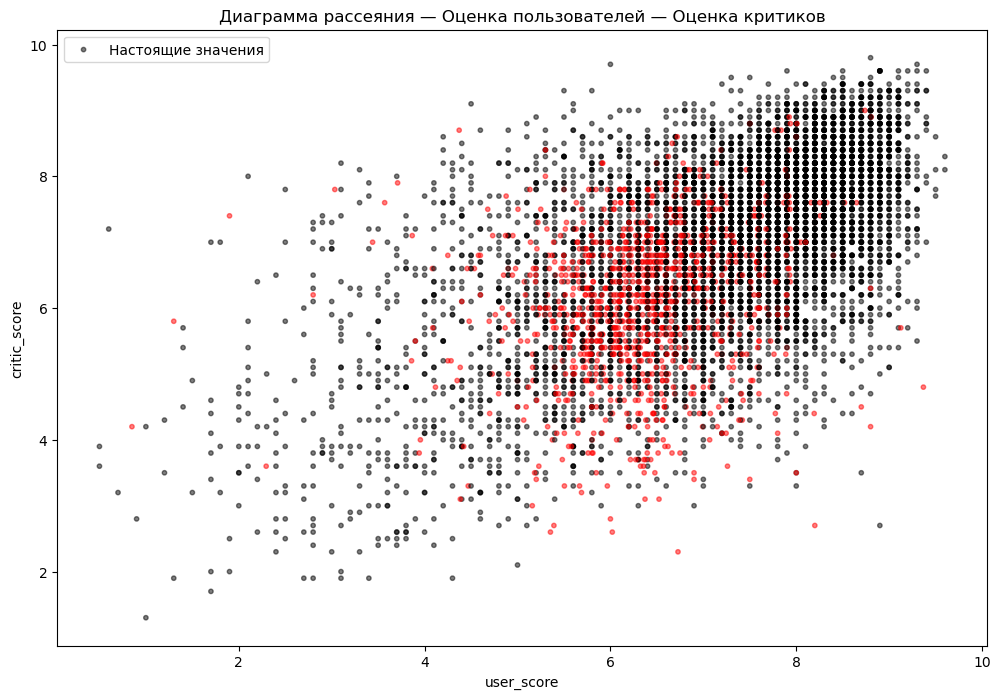

In [102]:
data.plot(kind='scatter', y='critic_score', x='user_score', figsize=(12, 8), alpha=0.5, s=10, c='value_category')
plt.legend(['Настоящие значения'])
plt.title('Диаграмма рассеяния — Оценка пользователей — Оценка критиков');

In [103]:
data[(data.user_score.isna()) & ~(data.critic_score.isna())].shape[0]

60

Пропущенные значения заполнились адекватно, осталось всего 61 неопознанных значения, их пропустим.

### Заполнение пропущенных значений в critic_scores

In [104]:
data.corr().style.format('{0:.2f}')

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales,diff_score
year_of_release,1.00,-0.10,-0.02,-0.15,0.07,0.01,-0.22,-0.09,0.26
na_sales,-0.10,1.00,0.64,0.06,0.68,0.30,0.14,0.91,0.17
eu_sales,-0.02,0.64,1.00,0.08,0.80,0.28,0.12,0.84,0.19
jp_sales,-0.15,0.06,0.08,1.00,0.08,0.14,0.16,0.30,-0.04
other_sales,0.07,0.68,0.80,0.08,1.00,0.28,0.10,0.81,0.19
critic_score,0.01,0.30,0.28,0.14,0.28,1.00,0.58,0.33,0.41
user_score,-0.22,0.14,0.12,0.16,0.10,0.58,1.00,0.16,-0.50
total_sales,-0.09,0.91,0.84,0.30,0.81,0.33,0.16,1.00,0.18
diff_score,0.26,0.17,0.19,-0.04,0.19,0.41,-0.50,0.18,1.00


In [105]:
data[(data.critic_score.isna()) & ~(data.user_score.isna())]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,diff_score,value_category
359,just dance 2014,Wii,2013,Misc,1.88,1.39,0.00,0.31,NaN,6.2,E10+,3.58,NaN,black
437,club penguin: elite penguin force,DS,2008,Adventure,1.87,0.97,0.00,0.30,NaN,8.0,E,3.14,NaN,black
505,imagine: babyz,DS,2007,Simulation,1.30,1.26,0.00,0.31,NaN,7.7,E,2.87,NaN,black
519,finding nemo,GBA,2003,Action,1.59,1.05,0.04,0.14,NaN,7.0,E,2.82,NaN,black
524,imagine: fashion designer,DS,2007,Simulation,1.32,1.19,0.00,0.30,NaN,7.6,E,2.81,NaN,black
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16618,xblaze: lost memories,PSV,2015,Adventure,0.01,0.00,0.00,0.00,NaN,7.0,M,0.01,NaN,black
16636,deal or no deal,PC,2006,Misc,0.00,0.01,0.00,0.00,NaN,7.5,E,0.01,NaN,black
16643,rugby challenge 3,XOne,2016,Sports,0.00,0.01,0.00,0.00,NaN,6.6,E,0.01,NaN,black
16654,ben 10 omniverse 2,X360,2013,Action,0.00,0.01,0.00,0.00,NaN,5.1,E10+,0.01,NaN,black


Циклом пройдёмся по 556 значениям (значений не так много, поэтому цикл будет не слишком затратен) и заполним их исходя из того, что оценки схожи по жанрам и платформам. 

Делаем те же действия, что и при заполнении значений в user_core

In [106]:
data['value_category'] = 'black'
for index in data[(data.critic_score.isna()) & ~(data.user_score.isna()) & (data.user_score >= 4)].index:
    genre_local = data.loc[index, 'genre']
    platform_local = data.loc[index, 'platform']
    rating_local = data.loc[index, 'rating']
    sales_local = data.loc[index, 'total_sales']
    
    mask = ((data.genre == genre_local) & 
        (data.platform == platform_local) &
        (data.rating == rating_local) &
        (data.total_sales.between(sales_local - 0.2, sales_local + 0.2)))
    data.loc[index, 'critic_score'] = data[mask].user_score.median() + data[mask].diff_score.median()
    data.loc[index, 'value_category'] = 'red'

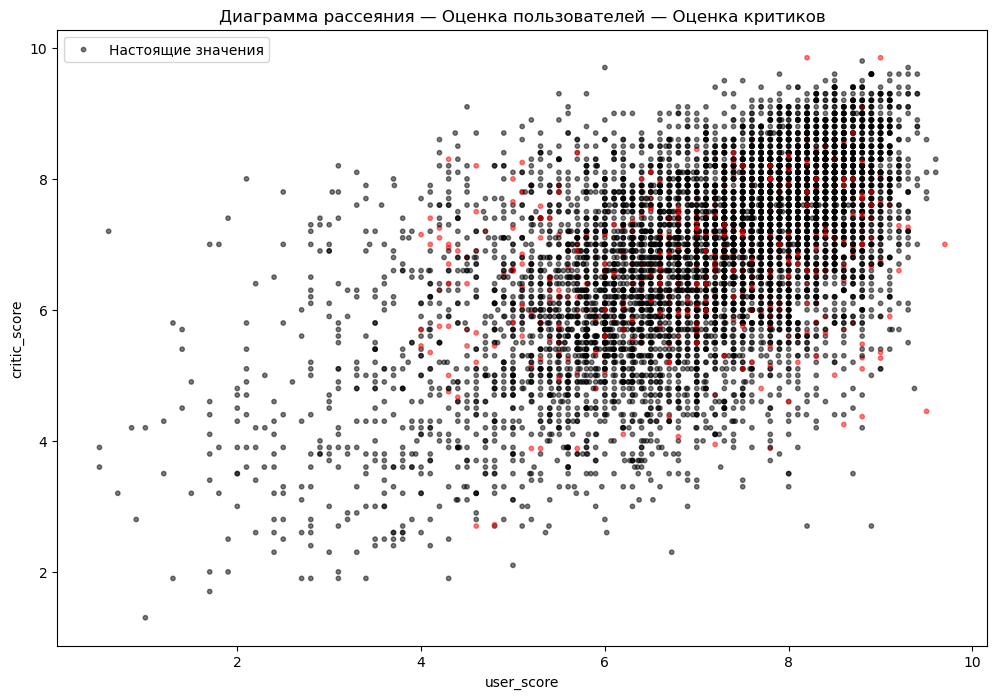

In [107]:
data.plot(kind='scatter', y='critic_score', x='user_score', figsize=(12, 8), alpha=0.5, s=10, c='value_category')
plt.title('Диаграмма рассеяния — Оценка пользователей — Оценка критиков')
plt.legend(['Настоящие значения']);

In [108]:
data[(data.critic_score.isna()) & ~(data.user_score.isna())].shape[0]

115

Большая часть пропущенных значений заполнилось приемлемо, нетронуты остались 115 значения, их можно пропустить.

### Проверка дубликатов

In [109]:
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating',
       'total_sales', 'diff_score', 'value_category'],
      dtype='object')

In [110]:
data.duplicated().sum()

0

Явных дубликатов нет.

In [111]:
data[data.duplicated(subset=['name', 'platform', 'genre', 'year_of_release'])]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,diff_score,value_category
4380,jampack volume 13,PS2,2005,Misc,0.37,0.01,0.00,0.06,NaN,NaN,NaN,0.44,NaN,black
4919,jampack winter 2003,PS2,2003,Misc,0.19,0.15,0.00,0.05,NaN,NaN,NaN,0.39,NaN,black
5336,tomb raider,PC,1996,Action,0.06,0.25,0.00,0.04,8.6,8.5,M,0.35,0.1,black
7278,summer athletics: the ultimate challenge sales),Wii,2008,Sports,0.00,0.20,0.00,0.01,NaN,NaN,NaN,0.21,NaN,black
7822,jampack: summer 2003,PS2,2003,Misc,0.09,0.07,0.00,0.02,NaN,NaN,NaN,0.18,NaN,black
9474,harvest moon ds sales),DS,2005,Simulation,0.00,0.00,0.13,0.00,NaN,NaN,NaN,0.13,NaN,black
9553,yu-gi-oh! nightmare troubadour sales),DS,2005,Action,0.00,0.03,0.10,0.00,NaN,NaN,NaN,0.13,NaN,black
10667,harvest moon ds cute sales),DS,2005,Simulation,0.00,0.00,0.10,0.00,NaN,NaN,NaN,0.10,NaN,black
12515,mega man battle network 5: double team ds sales),DS,2005,Role-Playing,0.06,0.00,0.00,0.00,NaN,NaN,NaN,0.06,NaN,black
12855,point blank ds sales),DS,2006,Shooter,0.05,0.00,0.00,0.00,NaN,NaN,NaN,0.05,NaN,black


In [112]:
data = data.drop_duplicates(subset=['name', 'platform', 'genre', 'year_of_release'])

In [113]:
data[data.duplicated(subset=['name', 'platform', 'genre', 'year_of_release'])]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,diff_score,value_category


In [114]:
data[data.duplicated(subset=['name', 'platform', 'year_of_release'])]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,diff_score,value_category


In [115]:
data[data.duplicated(subset=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'])]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,diff_score,value_category
1000,state of emergency,PS2,2002,Action,0.86,0.67,0.00,0.22,7.1,5.7,M,1.75,1.4,black
1034,rockstar games double pack: grand theft auto i...,PS2,2003,Action,0.85,0.66,0.00,0.22,NaN,NaN,NaN,1.73,NaN,black
1171,jampack summer 2k,PS,2000,Misc,0.88,0.60,0.00,0.10,NaN,NaN,NaN,1.58,NaN,black
1188,smuggler's run,PS2,2000,Racing,0.77,0.60,0.00,0.20,7.9,6.8,T,1.57,1.1,black
1226,tiger woods 99 pga tour golf,PS,1997,Sports,0.85,0.58,0.00,0.10,NaN,NaN,NaN,1.53,NaN,black
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16710,samurai warriors: sanada maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,NaN,black
16711,lma manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01,NaN,black
16712,haitaka no psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,NaN,black
16713,spirits spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01,NaN,black


Довольно много дубликатов по значениям продаж, скорее всего это связанно с округлением значений, тогать их не стоит.

## Исследовательский анализ данных

###  
Посмотрим, сколько игр выпускалось в разные годы.

Построим столбчатую диаграмму количества выпущенных игр по годам.

In [116]:
year_grouped = data.groupby('year_of_release').agg({'name' : 'count'})
year_grouped.columns = ['count']

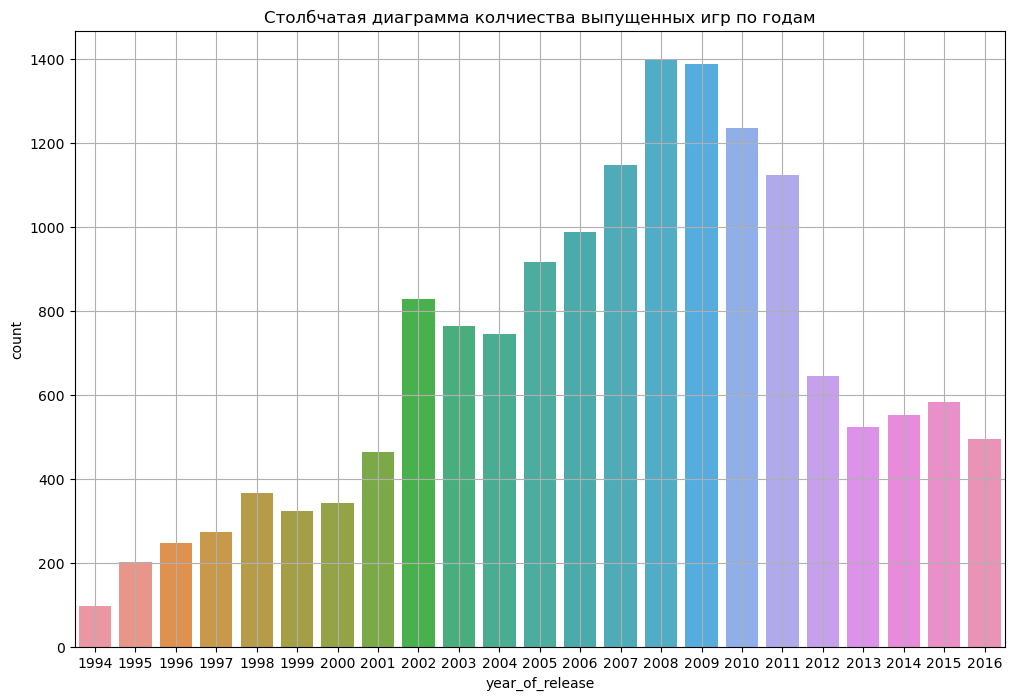

In [117]:
plt.figure(figsize=(12, 8))
sns.barplot(data=year_grouped,  y='count', x=year_grouped.index)
plt.grid(True)
plt.title('Столбчатая диаграмма колчиества выпущенных игр по годам');

Больше всего игр было выпущено в 2008-2009 годах, со показателями более 800 игр в год. Года с 2002 по 2011 являют собой основную массу данных, количество игр в этом сегменте не опускаются ниже 500. В то время как с 2012 идет тренд на убывание.

С 1994 года идёт плавный подъем, до 2002, где наблюдается резкий рост.

Сырые данные были представлены с 1980 года, но количество игр с 1980 по 1993 было меньше в сумме, чем 1994. Поэтому они были исключены из анализа. 

### 
Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и пострим распределение по годам. Узнаем за какой характерный срок появляются новые и исчезают старые платформы.

In [118]:
platform_sales_grouped = data.groupby('platform').agg({'total_sales' : 'sum'}).sort_values(by='total_sales', ascending=False)

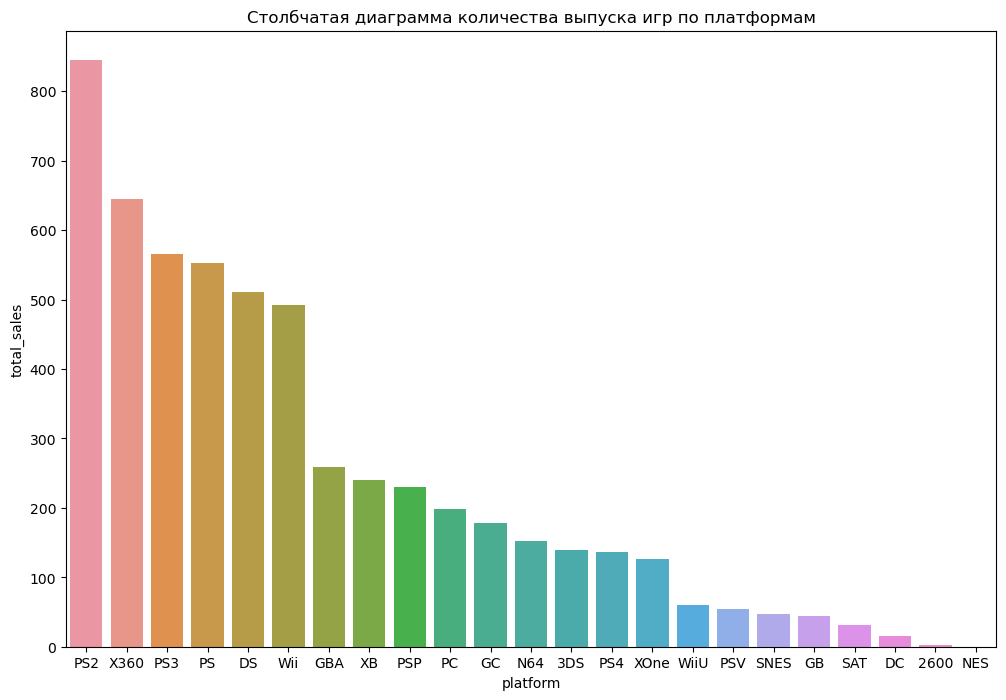

In [119]:
plt.figure(figsize=(12, 8))
sns.barplot(data = platform_sales_grouped, x=platform_sales_grouped.index, y='total_sales')
plt.title('Столбчатая диаграмма количества выпуска игр по платформам');

Данные по суммарным продажам по платформам можно выделить в 3 сегмента, первый с общими продажами не менее 500 млн., второй до 250 млн и третий продажи менее 100 млн.

Первый сегмент обгоняет второй по продажам в 2 раза.

Основные платформы представленны в первом сегменте, по нему и стоит строить распределение по годам.

In [120]:
platform_list = platform_sales_grouped.index[:6]

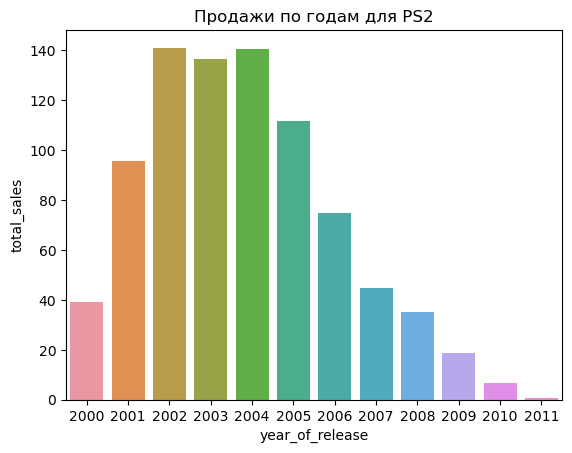

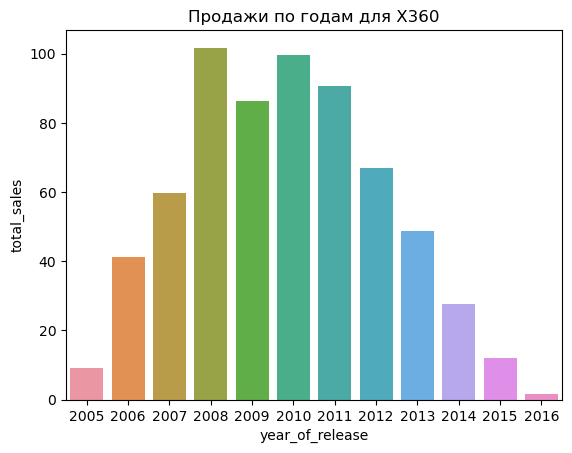

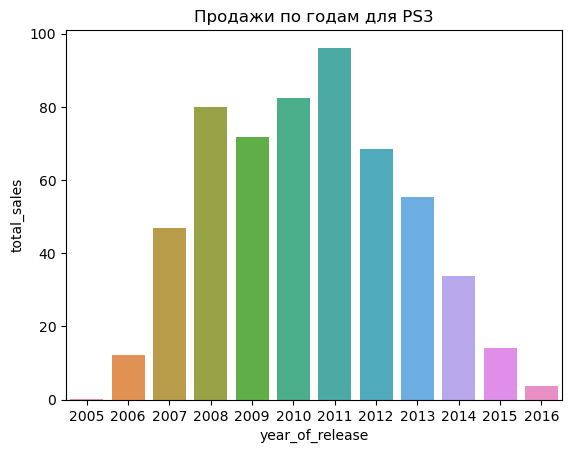

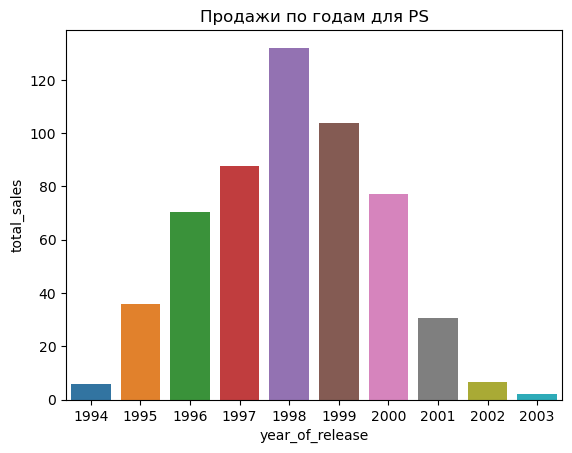

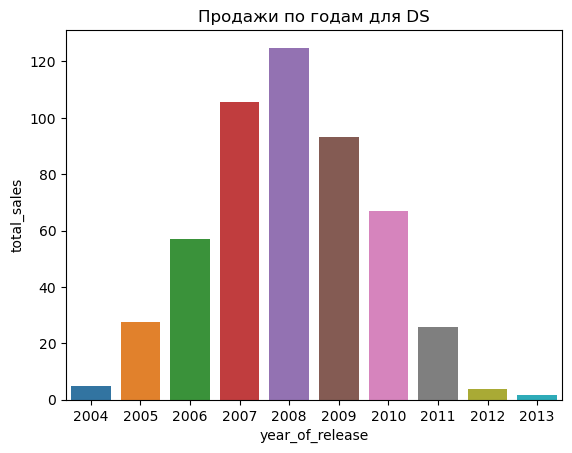

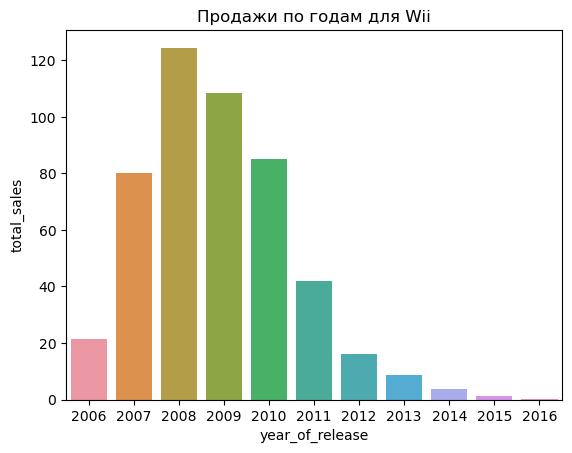

In [121]:
platform_year_sales_grouped = data.groupby('year_of_release')
for platform in platform_list:
    data_grouped = data[data.platform == platform].groupby('year_of_release').agg({'total_sales' : 'sum'})
    sns.barplot(data=data_grouped, x=data_grouped.index, y='total_sales')
    plt.title(f'Продажи по годам для {platform}')
    plt.show()

**Оснавная часть продаж происходит за 3-4 года. После чего, через год появляется новая платформа, затмевающая старую.**

### 
Возьмем данные за соответствующий актуальный период. И определим платформы лидирующие по продажам, их растут или падение. Выберем несколько потенциально успешных платформ.

Актуальным периодом буду считать данные с 2013 года.

In [122]:
actual_data_grouped = (data[data.year_of_release >= 2012]
                       .groupby('platform')
                       .agg({'total_sales' : 'sum'})
                       .sort_values(by='total_sales', ascending=False))

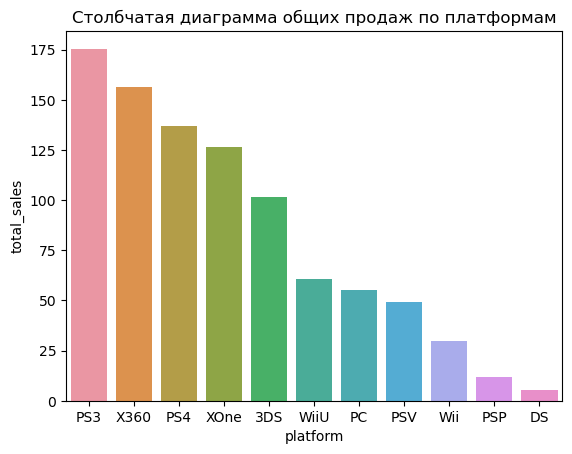

In [123]:
sns.barplot(data = actual_data_grouped, x=actual_data_grouped.index, y='total_sales')
plt.title('Столбчатая диаграмма общих продаж по платформам');

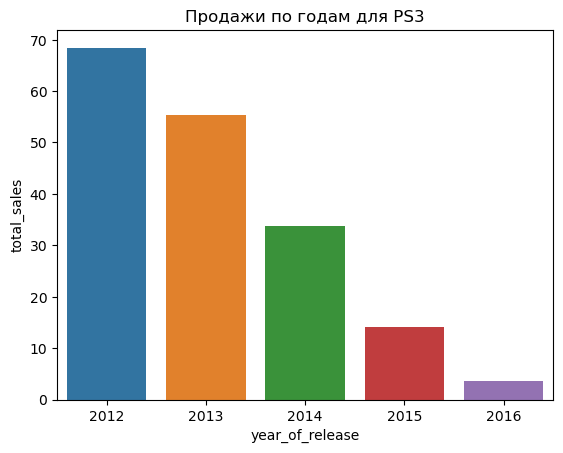

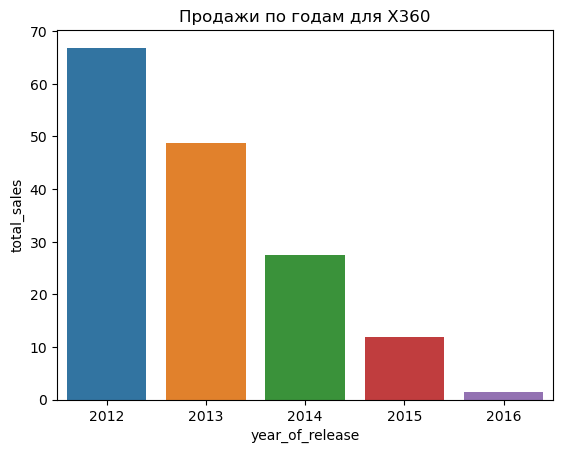

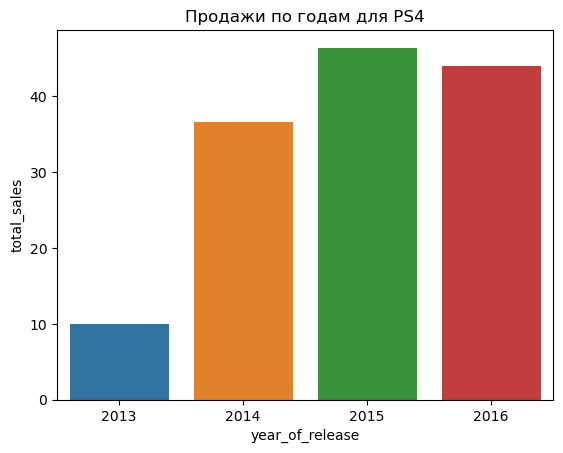

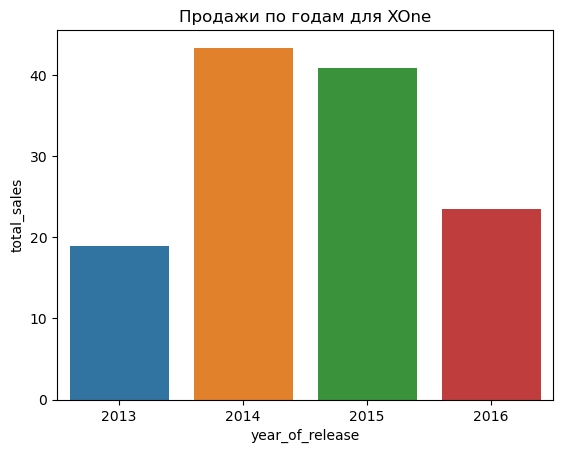

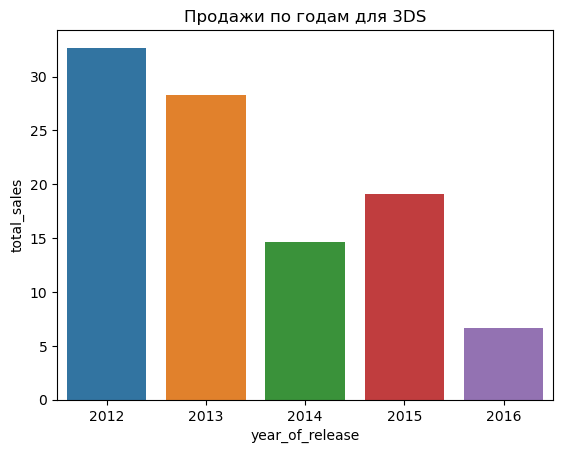

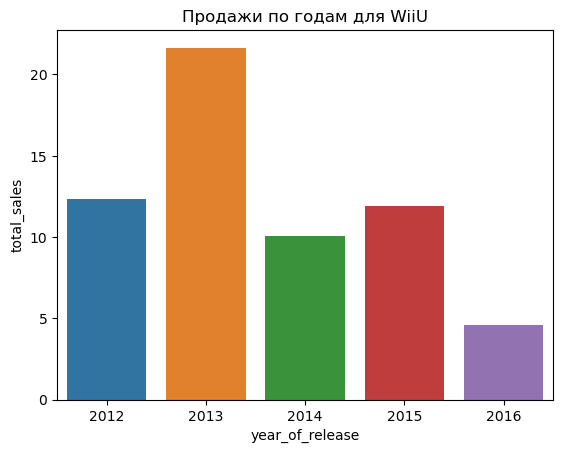

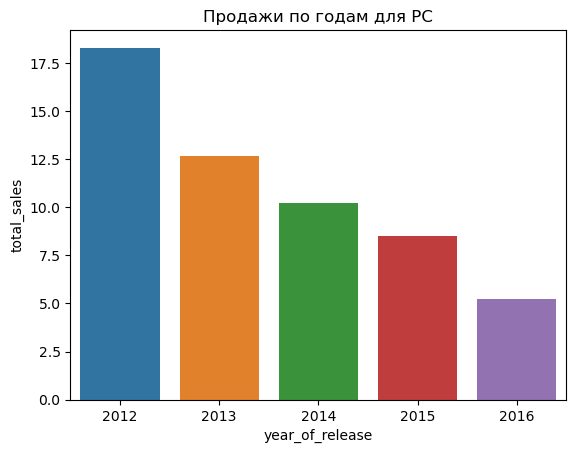

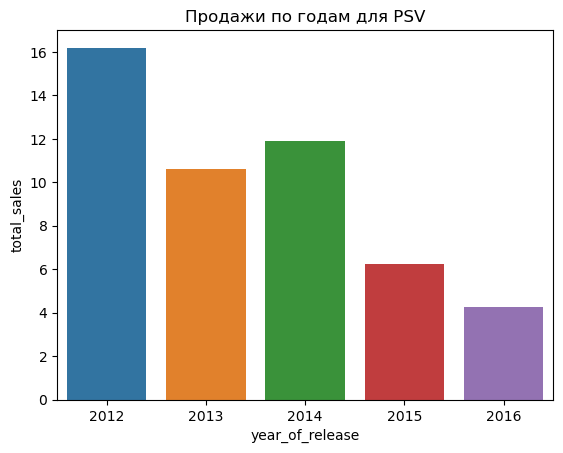

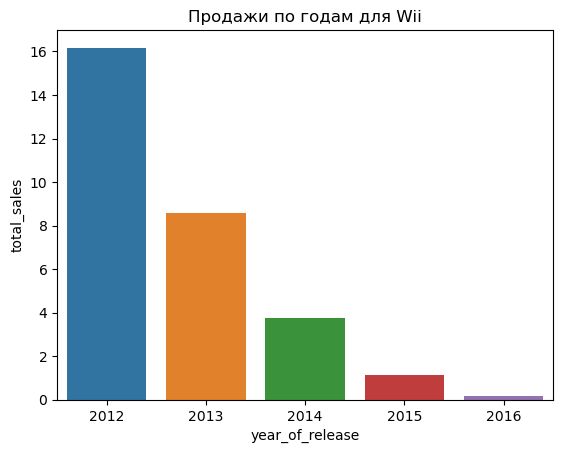

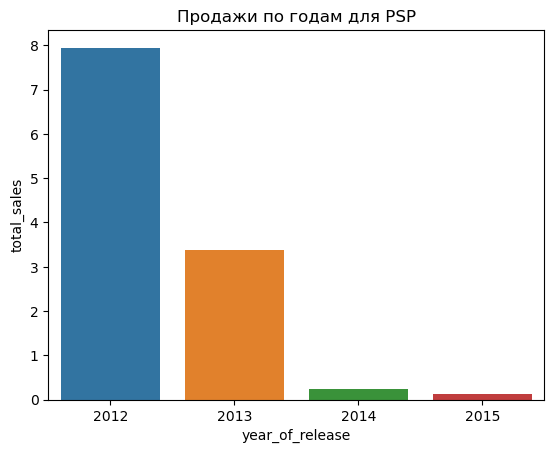

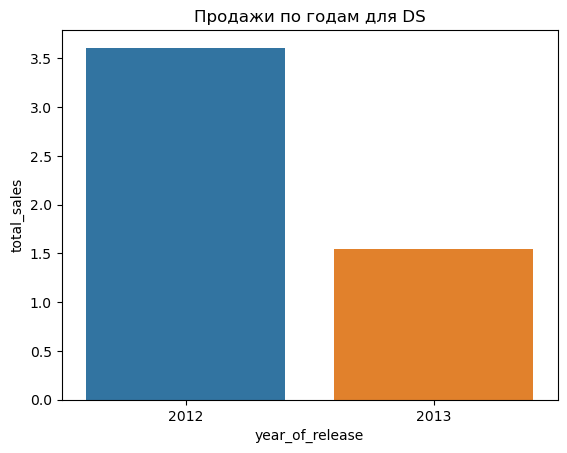

In [124]:
platform_list = actual_data_grouped.index
for platform in platform_list:
    data_grouped = (data[(data.year_of_release >= 2012) & (data.platform == platform)]
                    .groupby('year_of_release')
                    .agg({'total_sales' : 'sum'}))
    sns.barplot(data=data_grouped, x=data_grouped.index, y='total_sales')
    plt.title(f'Продажи по годам для {platform}')
    plt.show()

Лидирующими платформами являются PS4, XOne, PS3, X360

Продажи для PS4 в следующем году предпологаемо будут иметь такие же или более высокие значения. Ситуация спорнее для XOne, т.к. в 2016 году продажи проседают, но это скорее всего связано с общей тенденцией к уменьшению продаж.

Продажи для платформ PS3 и X360 уже 4-й год уменьшаются, они отжили свое и на них точно не стоит делать ставку.

### 
Построем график «ящик с усами» по глобальным продажам игр в разбивке по платформам.

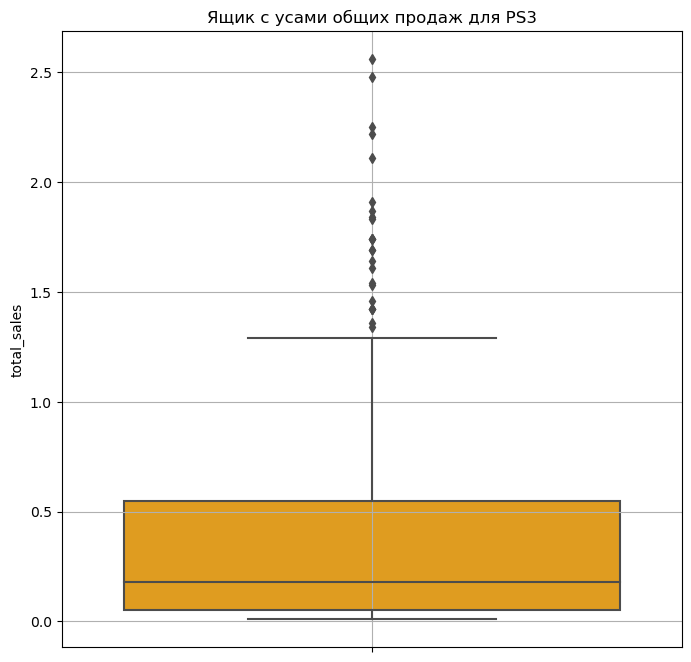

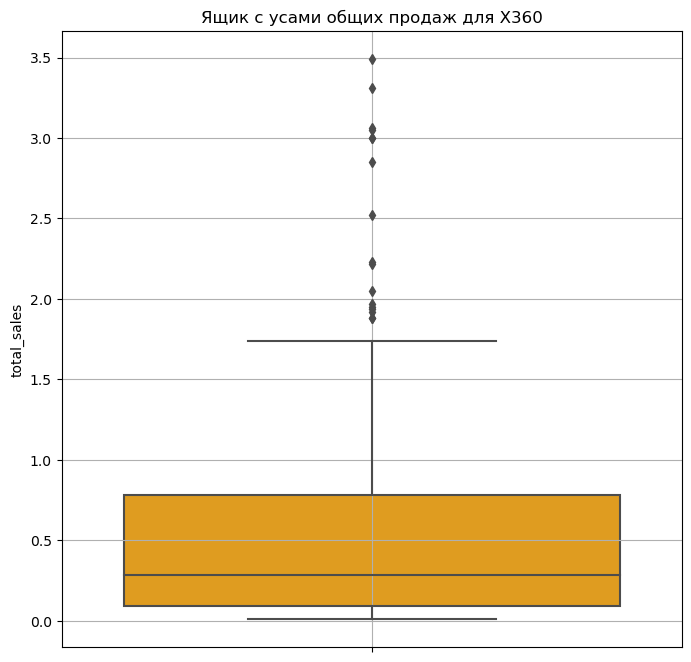

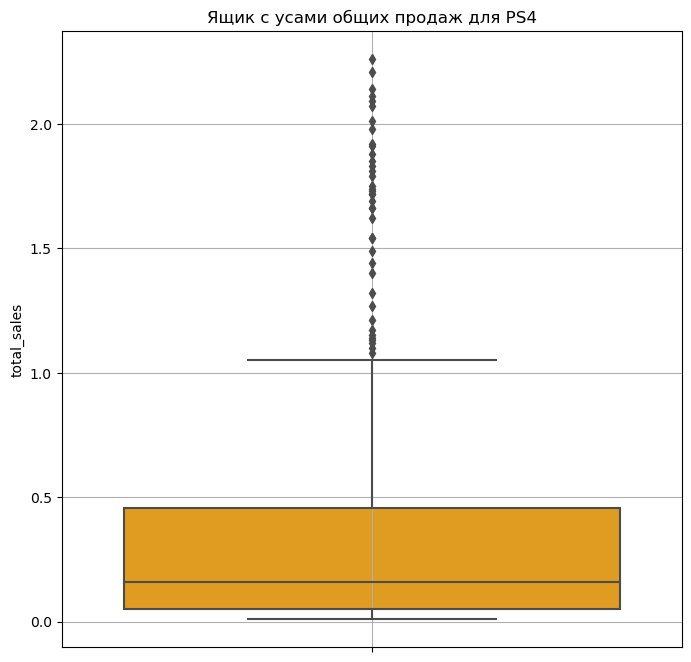

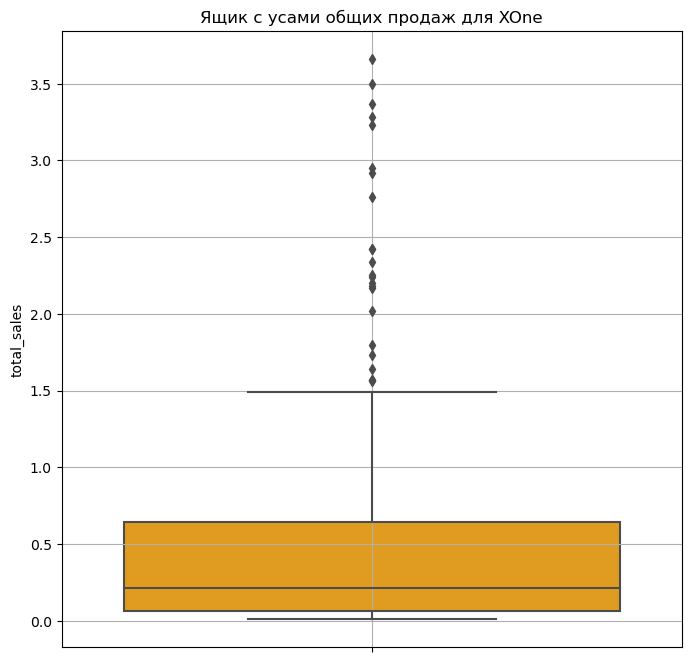

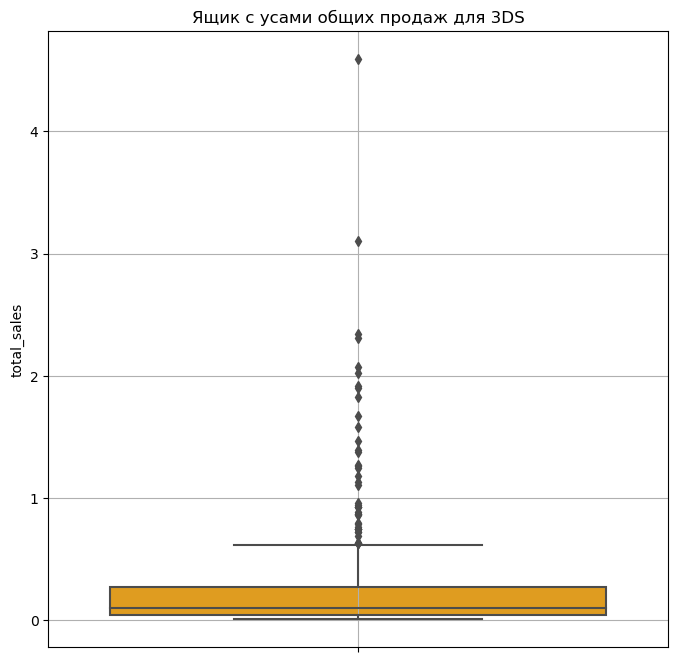

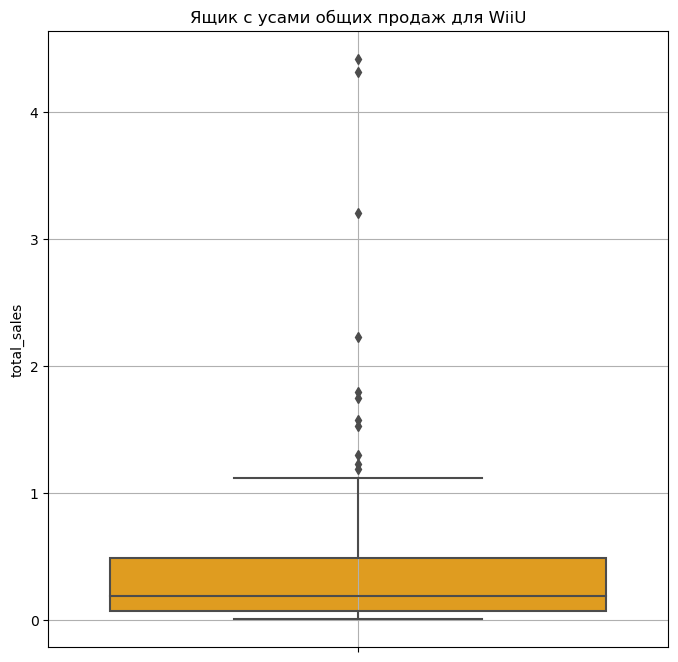

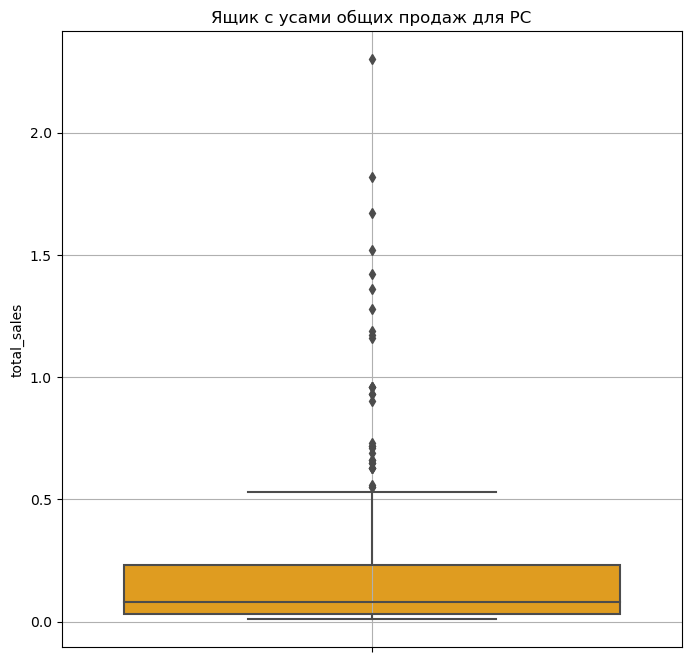

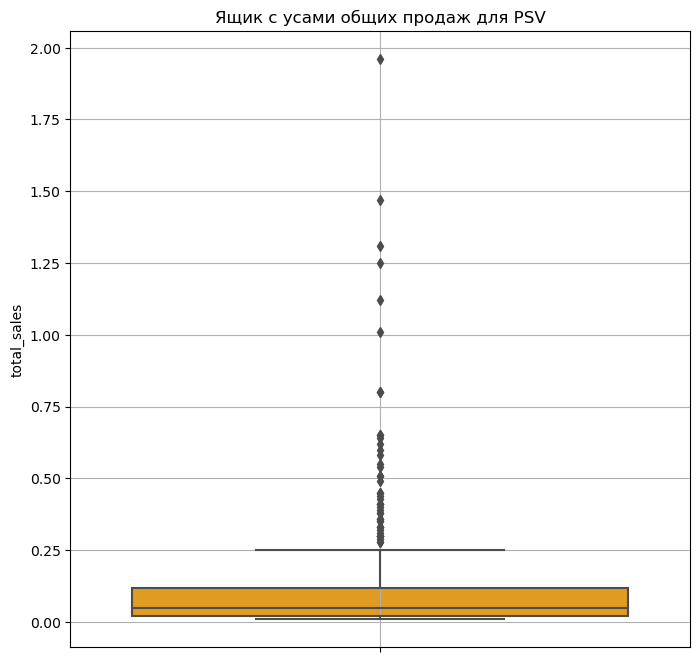

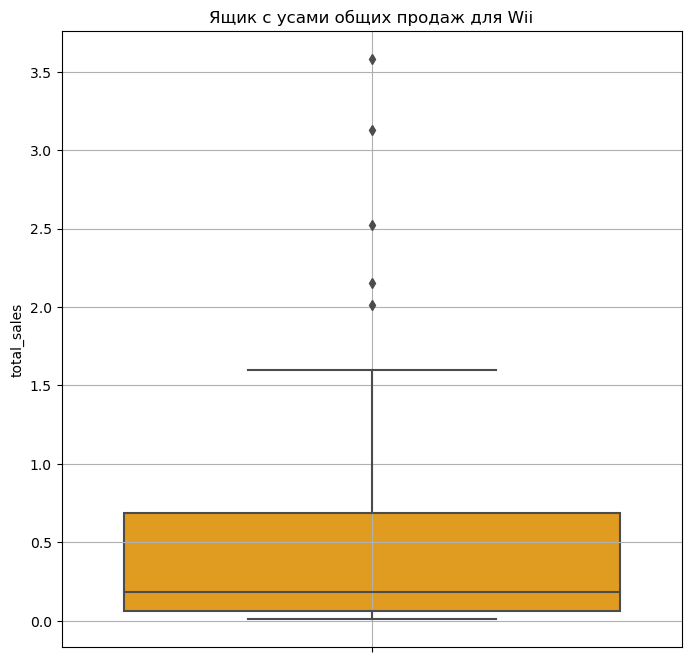

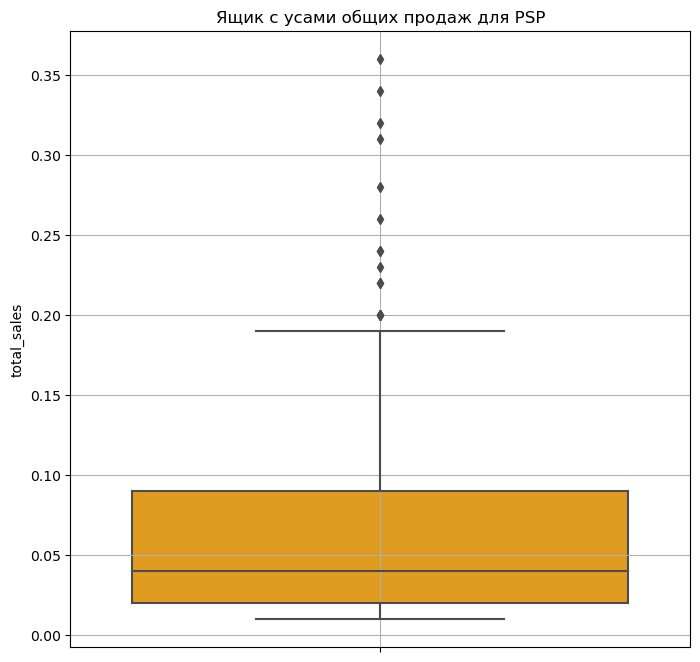

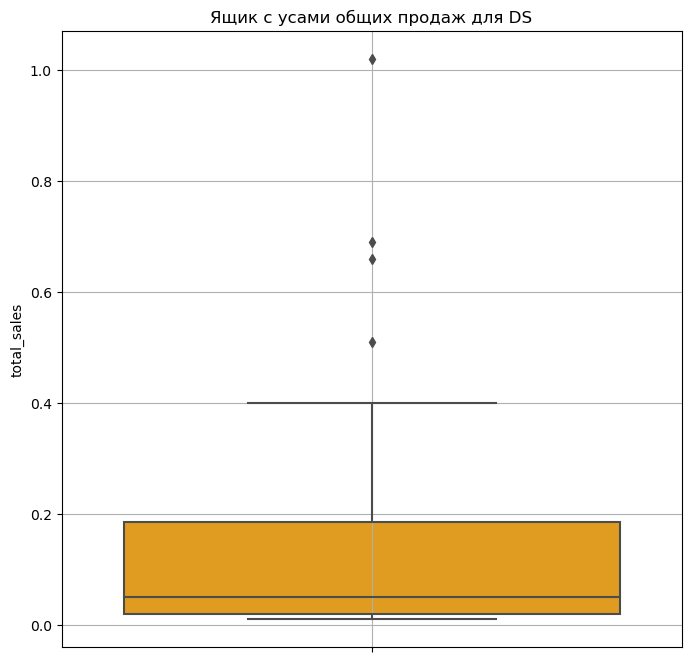

In [125]:
for platform in platform_list:
    local_data = data[(data.year_of_release >= 2012) & (data.platform == platform)]
    
    plt.figure(figsize=(8, 8))
    sns.boxplot(data = local_data, y = 'total_sales', color='orange')
    plt.grid(True)
    plt.title(f'Ящик с усами общих продаж для {platform}')
    plt.show()

**В целом распределение значений представляется схожим, смещенным влево. Сильные выбросы наблюдаются у 3х платформ - PC, PSV, WiiU и 3DS. Медианные значения в большенстве своем сосредоточены вокруг 0.2 млн.**

### 
Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

In [126]:
best_platform = data[data.platform =='PS3']

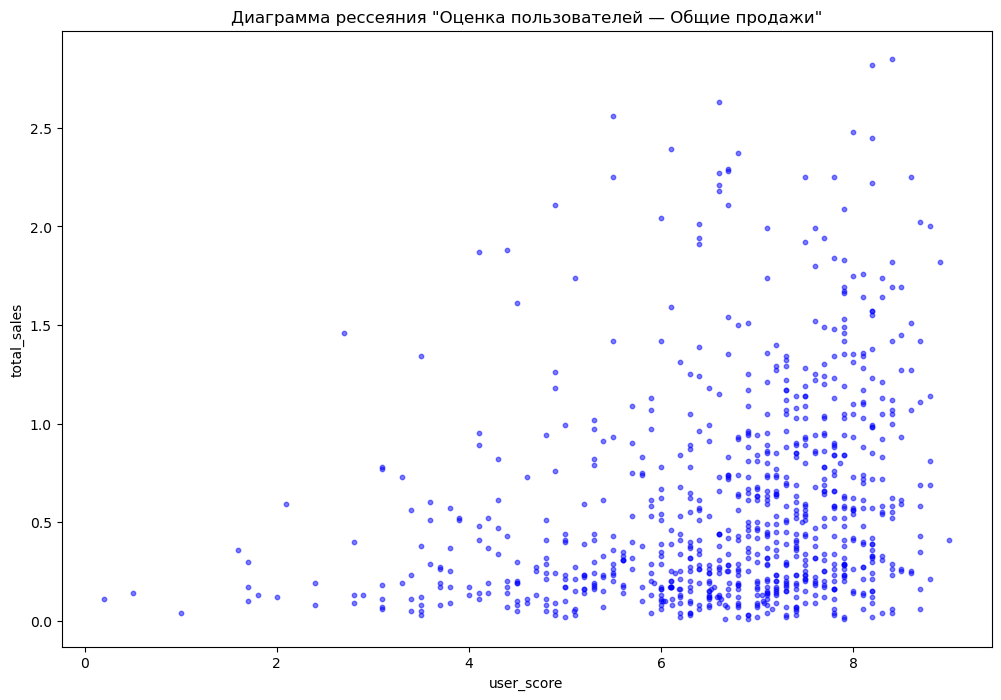

In [127]:
best_platform.plot(kind='scatter', x='user_score', y='total_sales', c='b', s=10, figsize=(12, 8), alpha=0.5)
plt.title('Диаграмма рессеяния "Оценка пользователей — Общие продажи"');

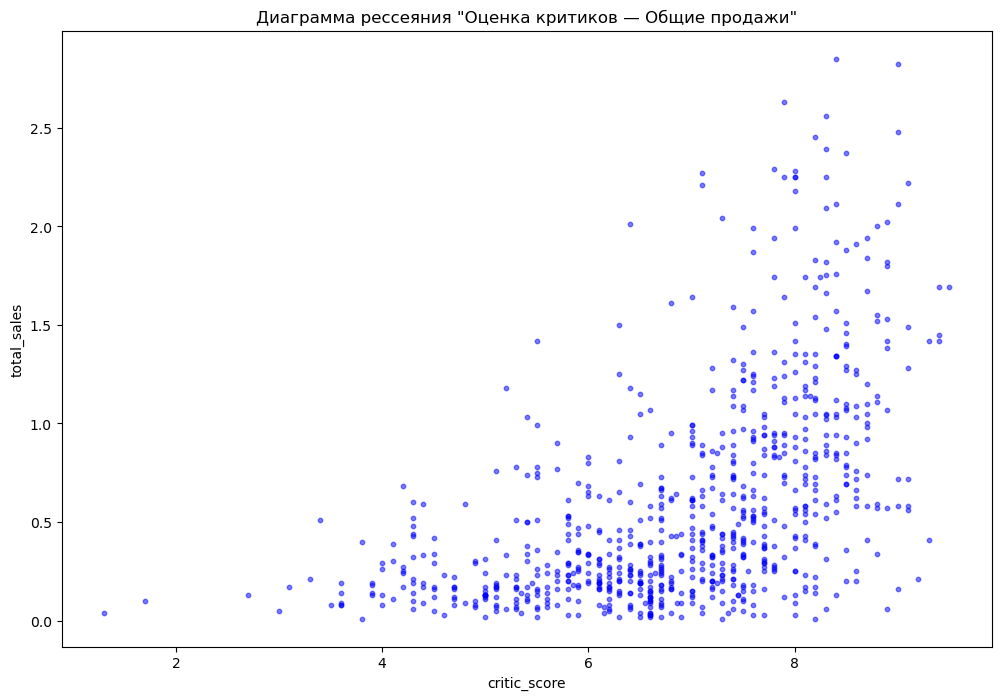

In [128]:
best_platform.plot(kind='scatter', x='critic_score', y='total_sales', c='b', s=10, figsize=(12, 8), alpha=0.5)
plt.title('Диаграмма рессеяния "Оценка критиков — Общие продажи"');

In [129]:
best_platform_corr = best_platform.corr().drop(['year_of_release', 'diff_score'], axis=1)
best_platform_corr.style.format('{0:.2f}')

,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
year_of_release,-0.21,-0.17,0.10,-0.18,0.01,-0.09,-0.18
na_sales,1.00,0.53,-0.02,0.77,0.47,0.18,0.87
eu_sales,0.53,1.00,0.09,0.92,0.42,0.20,0.84
jp_sales,-0.02,0.09,1.00,0.05,0.13,0.21,0.24
other_sales,0.77,0.92,0.05,1.00,0.50,0.23,0.94
critic_score,0.47,0.42,0.13,0.50,1.00,0.61,0.53
user_score,0.18,0.20,0.21,0.23,0.61,1.00,0.26
total_sales,0.87,0.84,0.24,0.94,0.53,0.26,1.00
diff_score,0.30,0.20,-0.12,0.25,0.40,-0.45,0.26


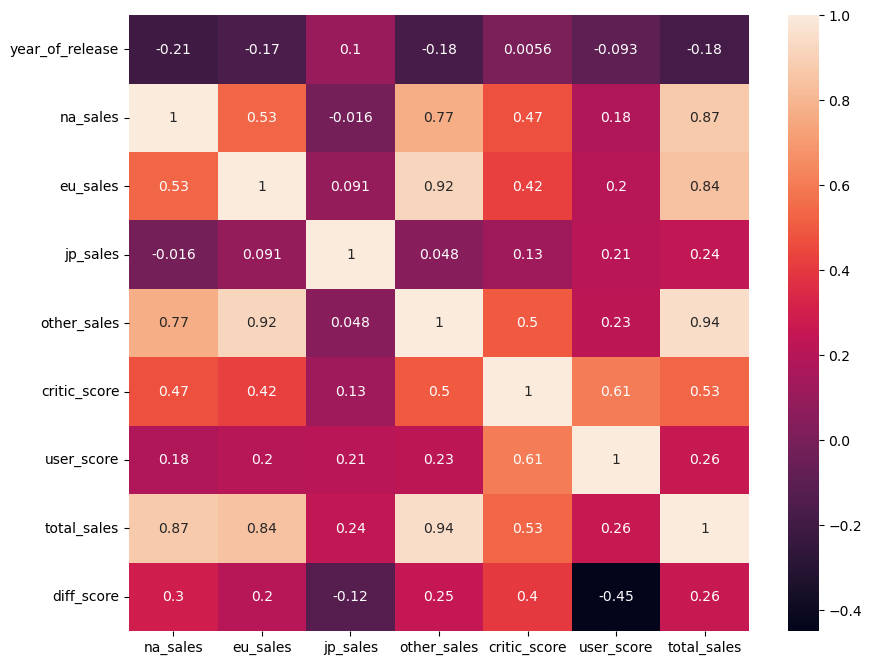

In [130]:
plt.figure(figsize=(10, 8))
sns.heatmap(best_platform_corr, annot=True);

Оценка критиков объясняет общие сборы в `54%`, в то время как оценка пользователей находится в районе `26%`, что почти что незначительно.

Сами же оценки коррелируют между собой со значением в 0.55, не делать вывод, критики ли влияют на критиков или же наоборот нельзя. Скорее всего эффект двусторонний.

Отдельно стоит отметить, что оценки критиков не коррелируют с продажами в японии. Из чего можно предположить, что данные об оценках критиков собраны из источников, которые не читают японцы.

### 
Соотнесем выводы с продажами игр на других платформах.

In [131]:
data.drop('diff_score', axis=1, inplace=True)

In [132]:
data_for_heatmaps = data.drop('year_of_release', axis=1)

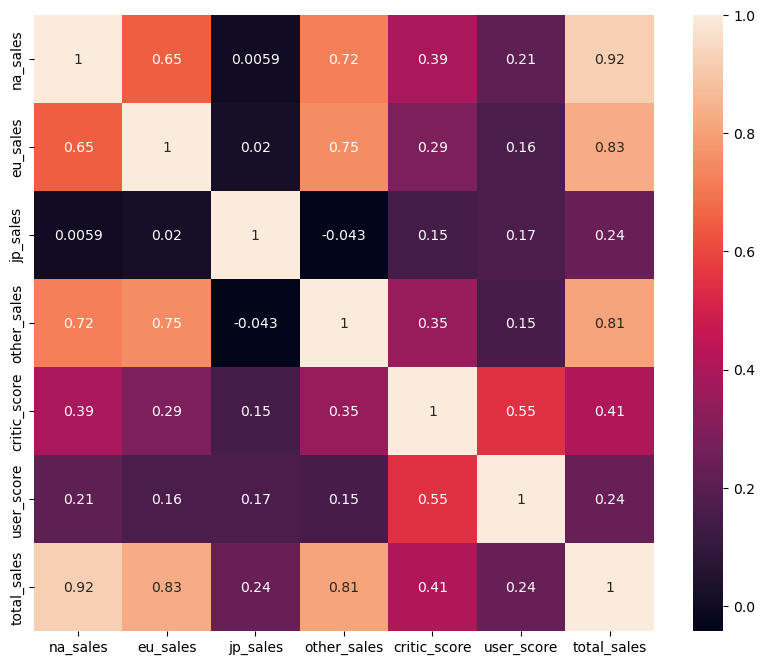

In [133]:
plt.figure(figsize=(10, 8))
sns.heatmap(data_for_heatmaps[data_for_heatmaps.platform == 'PS2'].corr(), annot=True);

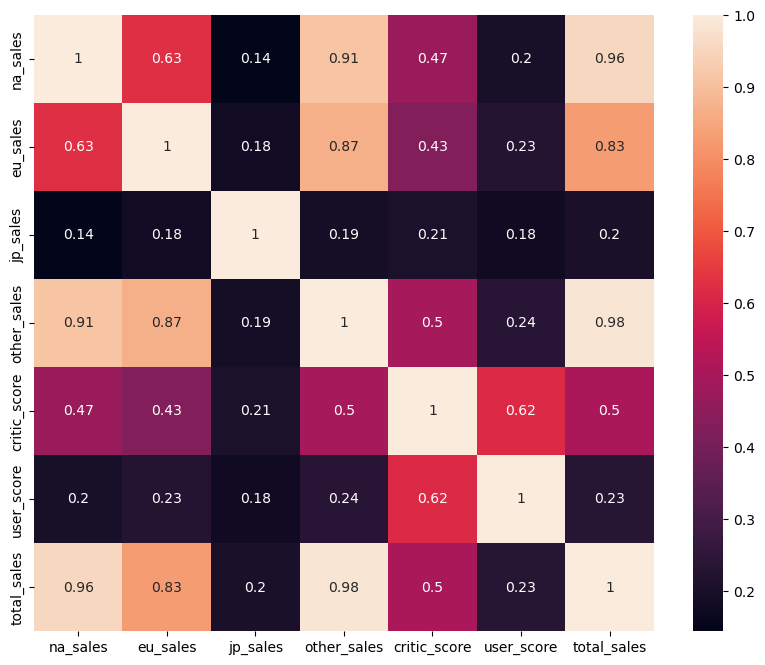

In [134]:
plt.figure(figsize=(10, 8))
sns.heatmap(data_for_heatmaps[data_for_heatmaps.platform == 'X360'].corr(), annot=True);

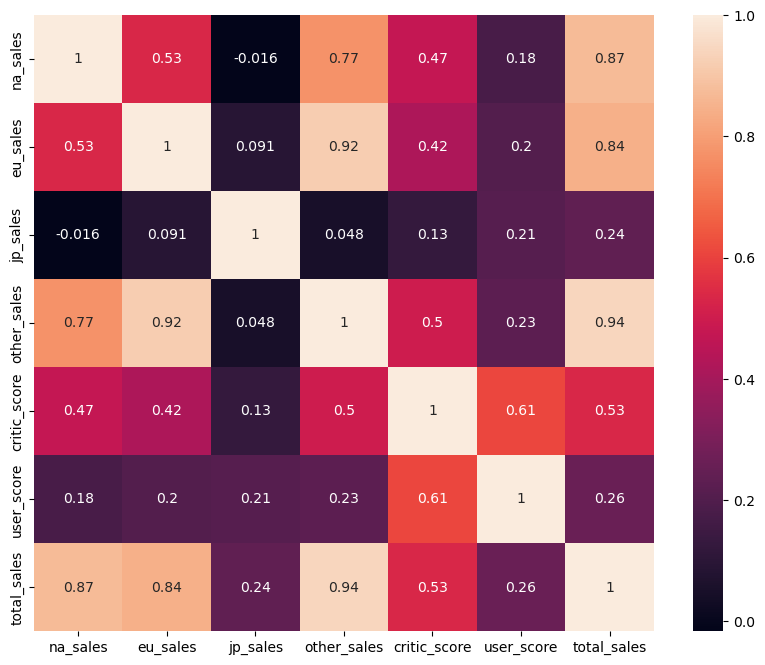

In [135]:
plt.figure(figsize=(10, 8))
sns.heatmap(data_for_heatmaps[data_for_heatmaps.platform == 'PS3'].corr(), annot=True);

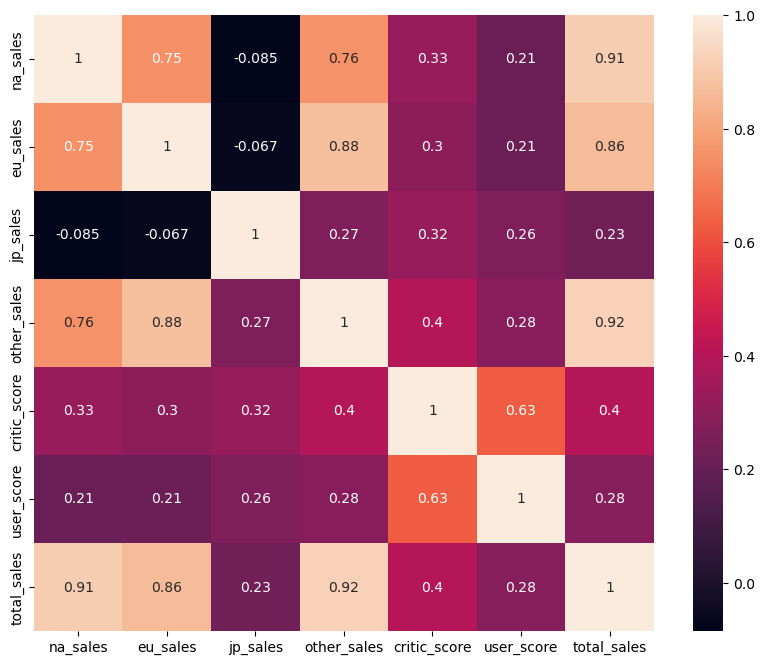

In [136]:
plt.figure(figsize=(10, 8))
sns.heatmap(data_for_heatmaps[data_for_heatmaps.platform == 'PS'].corr(), annot=True);

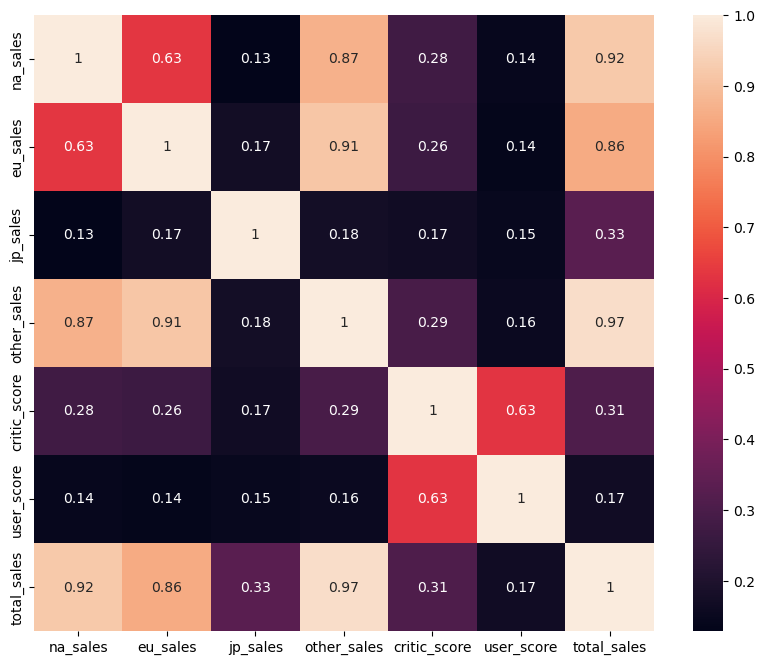

In [137]:
plt.figure(figsize=(10, 8))
sns.heatmap(data_for_heatmaps[data_for_heatmaps.platform == 'Wii'].corr(), annot=True);

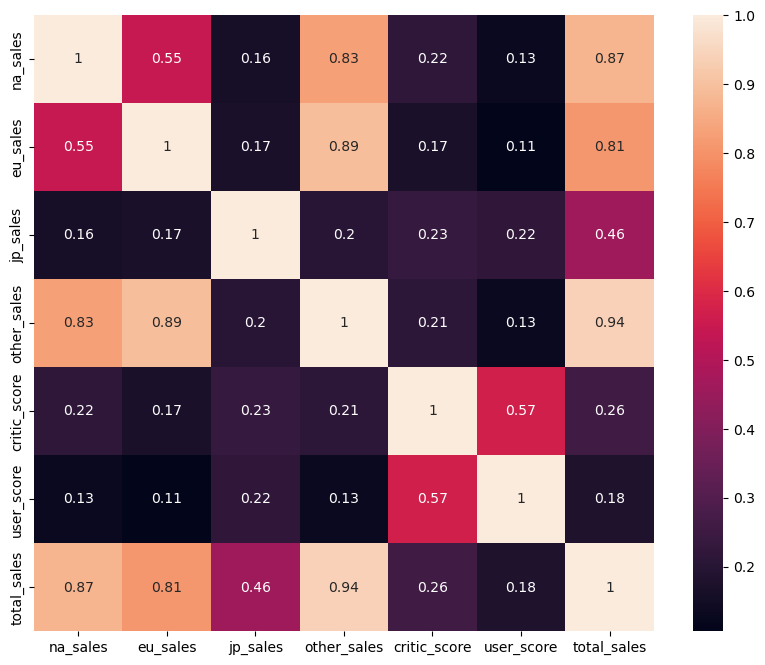

In [138]:
plt.figure(figsize=(10, 8))
sns.heatmap(data_for_heatmaps[data_for_heatmaps.platform == 'DS'].corr(), annot=True);

Корреляция на других популярных платформах имеет устойчивую тенденцию - оценки критиков имеют большую корреляцию на общие продажи, чем оценки пользователей.

Для выбора потенциально успешной игры, строит обращать больше внимания на оценки критиков, нежели на оценки игроков.

### 
Посмотрим на общее распределение игр по жанрам.

In [139]:
genre_grouped_sales = data.groupby('genre').agg({'total_sales' : 'sum'}).sort_values(by='total_sales', ascending=False)
genre_grouped_sales_counts = data.groupby('genre').agg({'name' : 'count'}).sort_values(by='name', ascending=False)

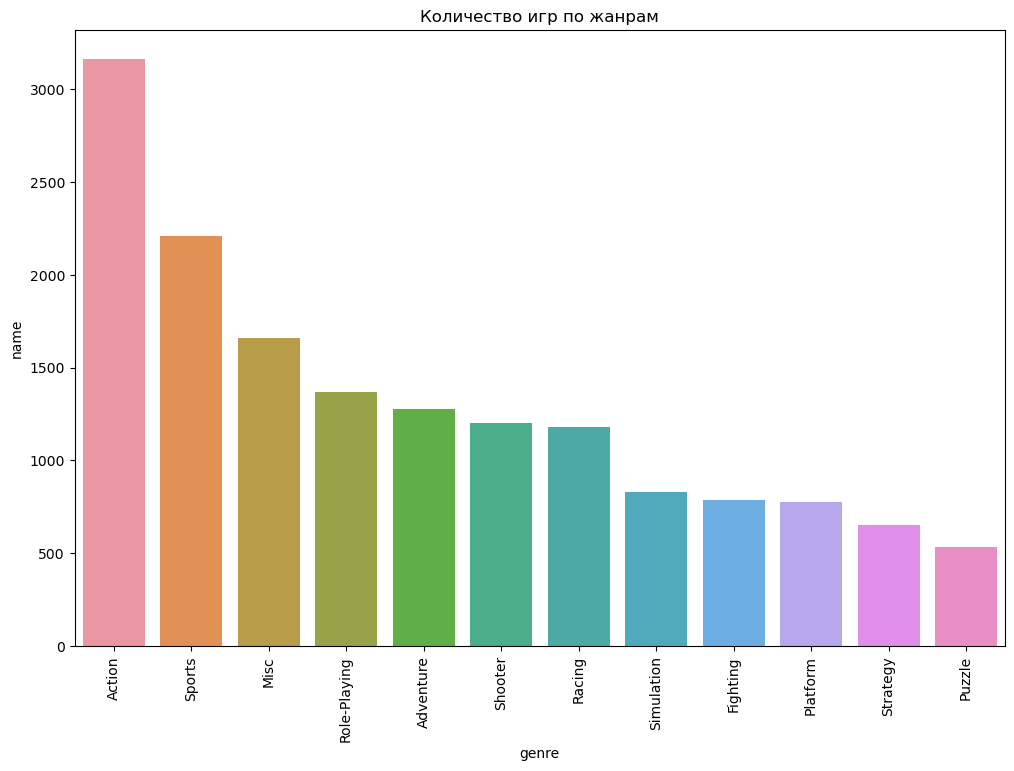

In [140]:
plt.figure(figsize=(12, 8))
sns.barplot(data=genre_grouped_sales_counts, x=genre_grouped_sales_counts.index, y='name')
plt.title('Количество игр по жанрам')
plt.xticks(rotation=90);

In [141]:
genre_grouped = data.groupby('genre').agg({'total_sales' : ['mean', 'median']})

In [142]:
genre_grouped.columns = genre_grouped.columns.droplevel(0)

In [143]:
genre_grouped = genre_grouped.sort_values(by='median', ascending=False)

In [144]:
genre_grouped.style.format('{0:.2f}')

,mean,median
genre,,
Platform,0.49,0.21
Sports,0.39,0.21
Shooter,0.46,0.20
Fighting,0.41,0.19
Action,0.37,0.17
Racing,0.38,0.17
Role-Playing,0.35,0.16
Misc,0.33,0.15
Simulation,0.35,0.15


Медианные значения лучше подойдут для описания наиболее прибыльного жанра для менее рискованной рекламной компании т.к. в наших данных довольно много экстримально высоких значений.

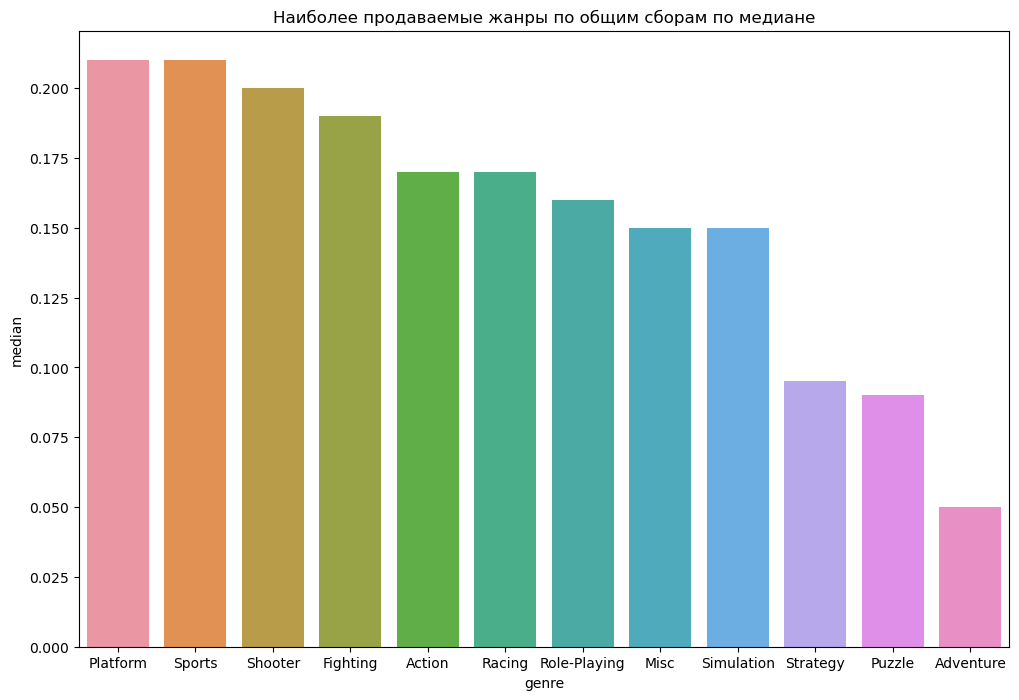

In [145]:
plt.figure(figsize=(12, 8))
sns.barplot(data=genre_grouped, x=genre_grouped.index, y='median')
plt.title('Наиболее продаваемые жанры по общим сборам по медиане');

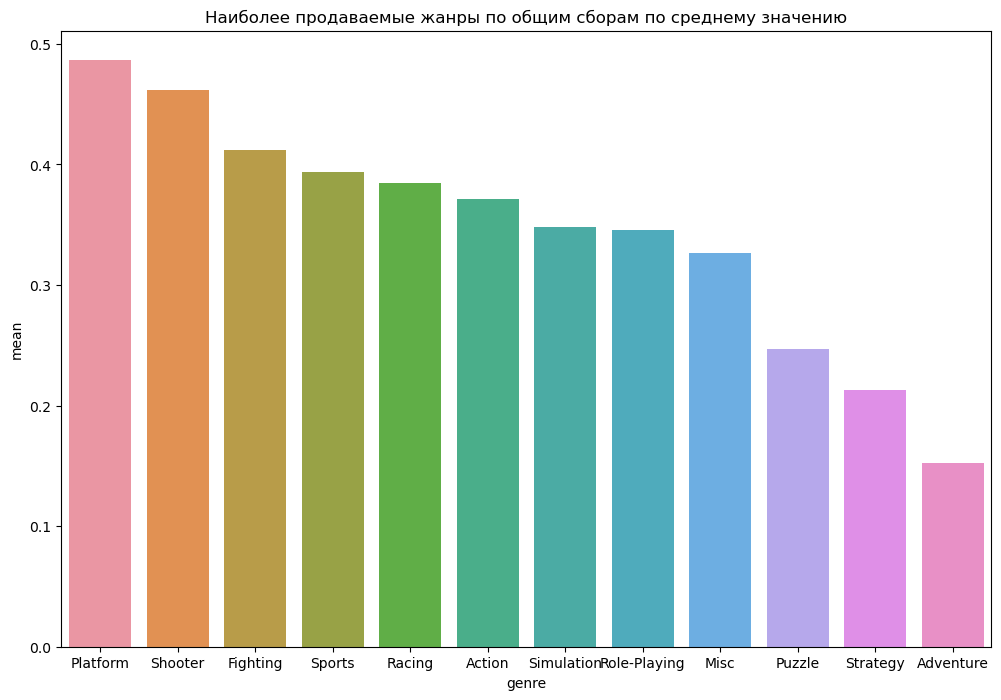

In [146]:
genre_grouped = genre_grouped.sort_values(by='mean', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(data=genre_grouped, x=genre_grouped.index, y='mean')
plt.title('Наиболее продаваемые жанры по общим сборам по среднему значению');

Лучшие жанры по медианным и средним значениям являются платформеры, шутеры, файтинги и спорт-игры. По безопасной рекламной стратегии выделяются жанры платформеры и спорт-игры, но довольно слабо. Для более рисковой стретигии стоит выбрать вместе с платформерами шутеры.

Puzzle, Strategy, Adventure андердоги среди всех представленных жанров.

## Портреты пользователей по регионам. 

### 
Определим пользователя каждого региона (NA, EU, JP):
Узнаем самые популярные платформы (топ-5) и опишем их различия в долях продаж.

In [147]:
reg_user = ['na_sales', 'eu_sales', 'jp_sales']

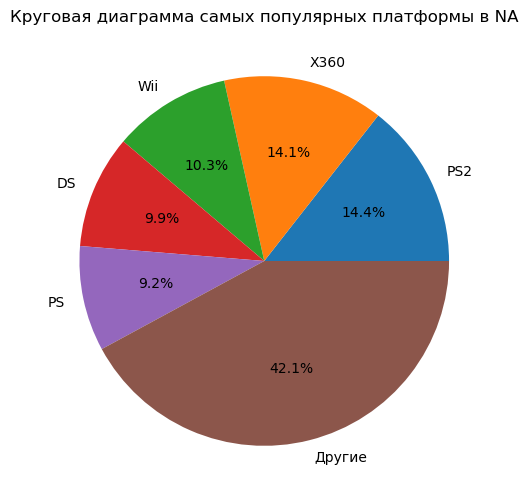

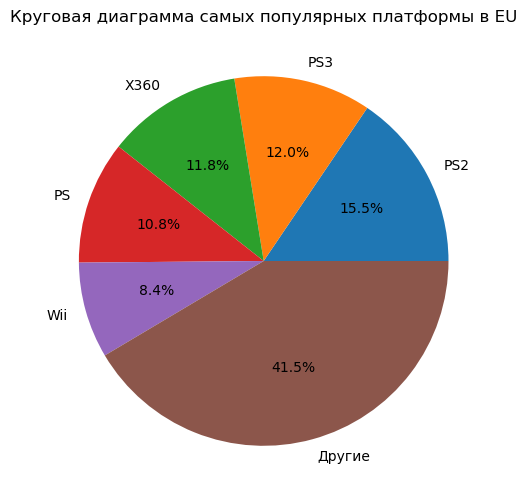

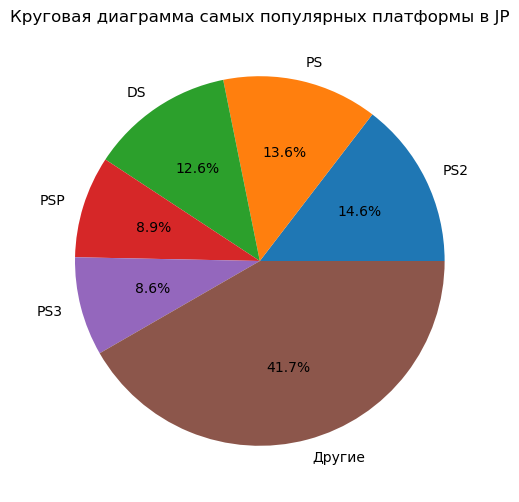

In [148]:
regs = {'na_sales' : 'NA', 'eu_sales' : 'EU', 'jp_sales' : 'JP'}

for user in reg_user:
    data_grouped = data.groupby('platform').agg({user : 'sum'}).sort_values(by=user, ascending=False)
    data_grouped['share']  = data_grouped[user] / data_grouped[user].sum()
    
    data_grouped_top = data_grouped.head()

    # Расчет столбца "Другие"
    other_sales = data_grouped[user].sum() - data_grouped_top[user].sum()
    other_share = 1 - data_grouped_top['share'].sum() # 1 (или 100%) минус доля топ-платформ
    
    # Добавление столбцы "Другие" в DataFrame
    other_row = pd.DataFrame({user: other_sales, 'share': other_share}, index=['Другие'])
    data_grouped_top = data_grouped_top.append(other_row)
    
    plt.figure(figsize=(8, 6))
    plt.pie(data_grouped_top['share'], labels=data_grouped_top.index, autopct='%1.1f%%')
    plt.title(f'Круговая диаграмма самых популярных платформы в {regs[user]}')
    plt.show()



В Северной Америке самыми платформами являются PS2, X360, Wii, PS, DS. Причем самыми успешными платформами являются PS2 и X360 c долями продаж в ~ 15%, остальные же составляют по 10% от всех продаж региона.

С Европе самыми популярнами платформами являются PS2, PS3, X360, PS, Wii. Явным лидером является PS2 c 16% долей продаж и худшим среди лучших Wii с 9%.

В Японии же лидируют PS, PS2, DS, PS3, SPS. Почти одинаковы по продажам как PS так и PS2 с 15% долями продаж, затем одинаково падают по общим продажам остальные платформы на ~3%.

### 
Узнаем самые популярные жанры (топ-5).

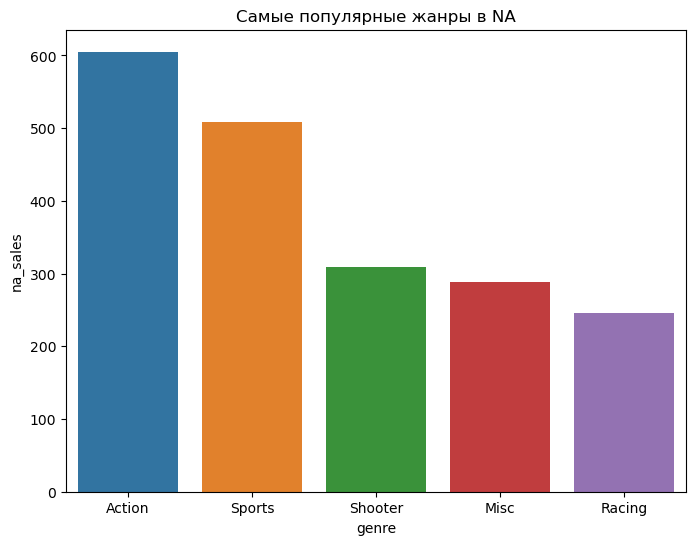

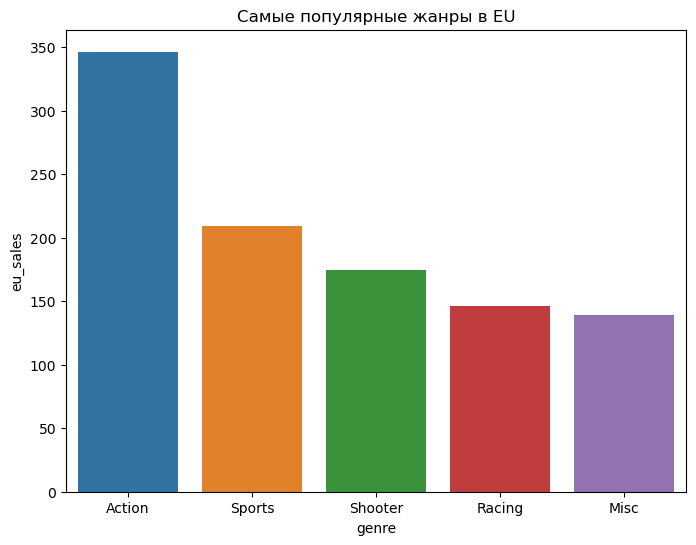

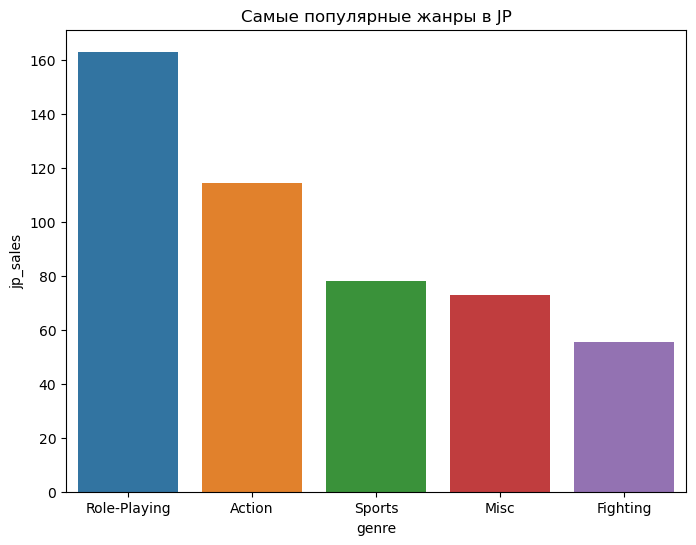

In [149]:
regs = {'na_sales' : 'NA', 'eu_sales' : 'EU', 'jp_sales' : 'JP'}

for user in reg_user:
    data_grouped_top = data.groupby('genre').agg({user : 'sum'}).sort_values(by=user, ascending=False)
    data_grouped_top = data_grouped_top.head()
    
    plt.figure(figsize=(8, 6))
    sns.barplot(data=data_grouped_top, x=data_grouped_top.index, y=user)
    plt.title(f'Самые популярные жанры в {regs[user]}')
    plt.show()

Самыми популярными жанрами в NA являются Action и Sports, затем с примерно одинаковыми показателями идут Shooter, Misc, Racing.

Самыме популярые жанры в EU схожи с NA, но с тремя отличиями: 1) Жанр Action сильно отрывается от всех остальных 2) Shooter ушел на 5-е место а Misc занял его 3-ю позицию 3) Жарнр Sports сильнее отстаёт от лидера

В Японии самым популярным жанром являеся Role-play, затем по тренду идут Action, Sports, Misc, Fighting.

В среднем наиболее выигрошно смотрятся жанры Action и Sports, только в Японии первенство Action заняли ролевые игры, в то время как они не попали в топы Европы и Северной Америки. Так же в Японии менее популярен жанр shooter, на его место в топ приходит Fighting.

### 
Узнаем влияет ли рейтинг ESRB на продажи в отдельном регионе.

## Проверка гипотез

In [150]:
data['rating'] = data.rating.fillna('PLUG')

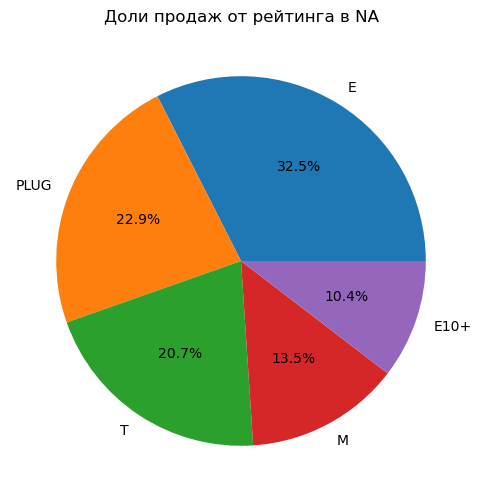

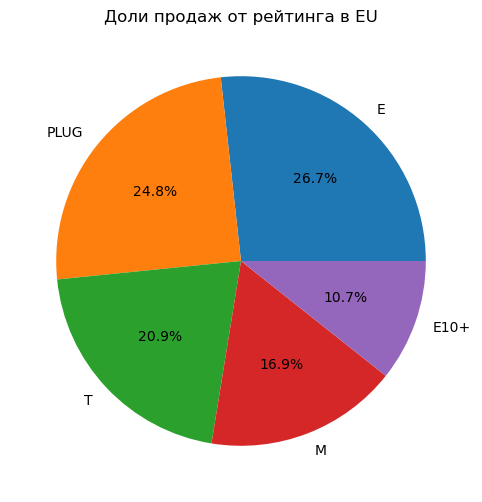

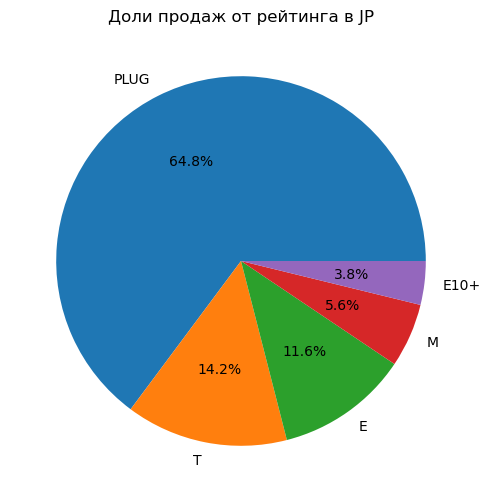

In [151]:
regs = {'na_sales' : 'NA', 'eu_sales' : 'EU', 'jp_sales' : 'JP'}

for user in reg_user:
    data_grouped_top = data.groupby('rating').agg({user : 'sum'}).sort_values(by=user, ascending=False)
    data_grouped_top['share'] = data_grouped_top[user] / data_grouped_top[user].sum()
    data_grouped_top = data_grouped_top.head()
    
    plt.figure(figsize=(8, 6))
    plt.pie(data_grouped_top['share'], labels=data_grouped_top.index, autopct='%1.1f%%')
    plt.title(f'Доли продаж от рейтинга в {regs[user]}')
    plt.show()


В целом доли продаж по регионам в зависимости от рейтинга в Северной Америке и Европе приблизительно равны.

В японии же больше чем для половины игр не имеет определённого ESRB рейтинга. Но само соотношение игр имеющих этот возрастной рейтинг примерно похож на значения в других регионах.

### 
Проверим гипотезу о равенстве оценок игр у пользователей PC и XOne

*Формулирование гипотезы:*

- Н0 - Средние оценок пользователей у платформ PC и XOne равны.

- H1 - Средние оценок пользователей не равны.

Критерий значимости в проверке гипотезы будет 1%.

In [152]:
data[data.platform.isin(['XOne', 'PC'])].groupby('platform').describe().T.loc['user_score'].style.format('{0:.2f}')

platform,PC,XOne
count,756.00,177.00
mean,7.07,6.54
std,1.51,1.38
min,1.40,1.60
25%,6.20,5.80
50%,7.50,6.80
75%,8.20,7.50
max,9.30,9.20


Дисперсии примерно равны.

In [153]:
alpha = 0.01

xone_scores = data[data.platform == 'XOne'].dropna().user_score
pc_scores = data[data.platform == 'PC'].dropna().user_score

In [154]:
result = st.ttest_ind(xone_scores, pc_scores)

if result.pvalue > alpha:
    print(f'Недостаточно оснований отклонить нулевую гипотезу. p-value равно {round(result.pvalue, 4)}')
else:
    print(f'Нуливая гипотеза отвергается. p-value равно {round(result.pvalue, 4)}')

Нуливая гипотеза отвергается. p-value равно 0.0


Используем метод bootstrap для подтверждения T-теста.

In [155]:
AB_diffrence = pc_scores.mean() - xone_scores.mean()

R_STATE = np.random.RandomState(32)
bootstrap = 5000
count = 0

for i in range(bootstrap):
    united_samples = pd.concat([pc_scores, xone_scores])
    subsample = united_samples.sample(frac=1, replace=True, random_state=R_STATE)
    
    subsample_a = subsample[:bootstrap]
    subsample_s = subsample[bootstrap:]
    bootstrap_diff = subsample_s.mean() - subsample_a.mean()
    
    if bootstrap_diff >= AB_diffrence:
        count += 1

pvalue = 1. * count / bootstrap

print('p-value =', pvalue)

if pvalue < alpha:
    print("Отвергаем нулевую гипотезу: скорее всего, целевой показатель увеличился")
else:
    print("Не получилось отвергнуть нулевую гипотезу: скорее всего, целевой показатель не увеличился")

p-value = 0.0
Отвергаем нулевую гипотезу: скорее всего, целевой показатель увеличился


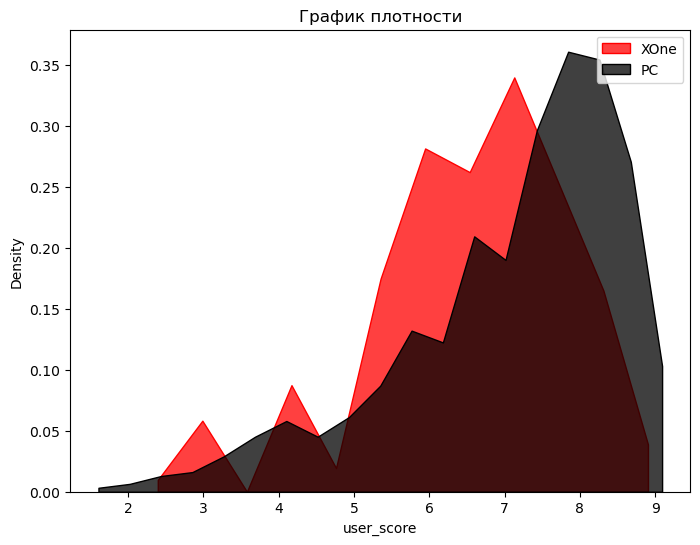

In [156]:
plt.figure(figsize=(8, 6))
sns.histplot(xone_scores, color='red', element="poly", stat='density')
sns.histplot(pc_scores, color='black', element="poly", stat='density')
plt.legend(['XOne', 'PC'])
plt.title('График плотности');

Наша гипотеза о равенстве двух средних в жанрах Action и Sports опроверглась.

Средние оценки между жанрами статистически значимо отличаются.

### 
Проверим гипотезу о равенстве оценок игр у пользователей в жанрах Action и Sports

*Формулирование гипотез*:

- Н0 - средние пользовательские рейтинги жанров Action и Sports равны.
- Н1 - средние пользовательские рейтинги для этих жанров не равны.

Критерий значимости так же будет 1%

In [157]:
data[data.genre.isin(['Action', 'Sports'])].groupby('genre').describe().T.loc['user_score'].style.format('{0:.2f}')

genre,Action,Sports
count,1938.00,1251.00
mean,6.89,6.94
std,1.41,1.51
min,0.30,0.20
25%,6.00,6.20
50%,7.10,7.20
75%,7.90,8.00
max,9.50,9.50


Дисперсии примерно равны.

In [158]:
alpha = 0.01

action_pool = data[data.genre == 'Action'].dropna().user_score
sports_pool = data[data.genre == 'Sports'].dropna().user_score

In [159]:
results = st.ttest_ind(action_pool, sports_pool)
if result.pvalue > alpha:
    print(f'Недостаточно оснований отклонить нулевую гипотезу. p-value равно {round(result.pvalue, 4)}')
else:
    print(f'Нуливая гипотеза отвергается. p-value равно {round(result.pvalue, 4)}')

Нуливая гипотеза отвергается. p-value равно 0.0


Проверим с помощью бутстрапа.

In [160]:
AB_diffrence = sports_pool.mean() - action_pool.mean()

bootstrap = 5000
count = 0

for i in range(bootstrap):
    united_samples = pd.concat([action_pool, sports_pool])
    subsample = united_samples.sample(frac=1, replace=True, random_state=R_STATE)
    
    subsample_a = subsample[:bootstrap]
    subsample_s = subsample[bootstrap:]
    bootstrap_diff = subsample_s.mean() - subsample_a.mean()
    
    if bootstrap_diff >= AB_diffrence:
        count += 1

pvalue = 1. * count / bootstrap

print('p-value =', pvalue)

if pvalue < alpha:
    print("Отвергаем нулевую гипотезу: скорее всего, целевой показатель увеличился")
else:
    print("Не получилось отвергнуть нулевую гипотезу: скорее всего, целевой показатель не увеличился")

p-value = 0.0
Отвергаем нулевую гипотезу: скорее всего, целевой показатель увеличился


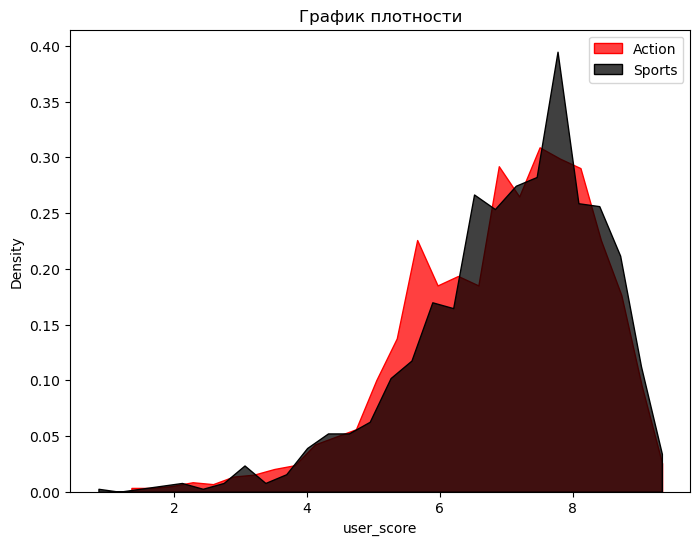

In [161]:
plt.figure(figsize=(8, 6))
sns.histplot(action_pool, color='red', element="poly", stat='density')
sns.histplot(sports_pool, color='black', element="poly", stat='density')
plt.legend(['Action', 'Sports'])
plt.title('График плотности');

## Общий вывод

<div style='border:solid blue 2px; padding: 10px'>
    
**Предобработка данных**

Были построены таблицы и графики распределений значений по столбцам для удаления выбросов, и редких значений. В ходе преообработки было удалено 6.4% данных. Была просчитана общая выручка для игры.
    
**Анализ данных**

Больщая часть игр выходила с 2002 по 2011 года. С периода с 2012 по 2016 объем продоваемых игр упал вдвое.
    
Данные общих продаж по платформам можно выделить в 3 сегмента, лидеры находятся в 3-м сегменте, с общими продажами игра на них не менее 500 млн. Это PS2, X360, PS3, PS, DS, Wii. Но эти платформы более не актуальны и им на смену идут следующее поколение платформ, расположенных во 2м сегменте Это платформы XOne, PS4, 3DS, N64, GC, PC.
    
Стоит выделить отдельно PS4, XOne. Для PS4 продолжаеся рост общего числа продаж игр на ней, а XOne имеет просадку, связанную главным образом с общей тенденцией уменьшения продаж игр, но все еще имеющую поненциал.
    
Было выявлено, что по самым популярным платформам оценка критиков хорошо кореллировала с общеми продажами и объясняла их в 54% случаев. Для мене популярных платформ это значение уменьшалось, но стабильно оказывалось выше оценок пользователей.
    
Для будущих рекламных компаний критерий оценки критиков обязательно стоит учесть.
    
Лучшие жанры по медианным и средним значениям являются платформеры, шутеры, файтинги и спорт-игры. По безопасной рекламной стратегии выделяются жанры платформеры и спорт-игры, но довольно слабо. Для более рисковой стретигии стоит выбрать вместе с платформерами шутеры.

Puzzle, Strategy, Adventure андердоги среди всех представленных жанров.
    
**Портреты пользователей по регионам**

В Северной Америке самыми платформами являются PS2, X360, Wii, PS, DS. Причем самыми успешными платформами являются PS2 и X360 c долями продаж в ~ 15%, остальные же составляют по 10% от всех продаж региона.

С Европе самыми популярнами платформами являются PS2, PS3, X360, PS, Wii. Явным лидером является PS2 c 16% долей продаж и худшим среди лучших Wii с 9%.

В Японии же лидируют PS, PS2, DS, PS3, SPS. Почти одинаковы по продажам как PS так и PS2 с 15% долями продаж, затем одинаково падают по общим продажам остальные платформы на ~3%.
    
Самыми популярными жанрами в NA являются Action и Sports, затем с примерно одинаковыми показателями идут Shooter, Misc, Racing.

Самыме популярые жанры в EU схожи с NA, но с тремя отличиями: 1) Жанр Action сильно отрывается от всех остальных 2) Shooter ушел на 5-е место а Misc занял его 3-ю позицию 3) Жарнр Sports сильнее отстаёт от лидера

В Японии самым популярным жанром являеся Role-play, затем по тренду идут Action, Sports, Misc, Fighting.

В среднем наиболее выигрошно смотрятся жанры Action и Sports, только в Японии первенство Action заняли ролевые игры, в то время как они не попали в топы Европы и Северной Америки. Так же в Японии менее популярен жанр shooter, на его место в топ приходит Fighting.
    
В целом, доли продаж по ESRB рейтингу не отличаются.
    
**Гипотезы**
    
Гипотеза о равенстве средних по платформам Xbox One и PC опроверглась. Сама платформа влияет на оценки пользователей.
    
Гипотеза о равенстве средних по жанрам Action и Sports опроверглась. Средние оценки пользователей в этих жанрах различны.